# Predict #
To be re-inserted into main Jupyter Notebook after.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For neural networks.
import keras as kr
# For data frames.
import pandas as pd
# For numerical arrays.
import numpy as np
# For preprocessing data.
import sklearn.preprocessing as pre
# For splitting data sets.
import sklearn.model_selection as mod
# For whitening.
import sklearn.decomposition as dec
# to write to csv file
import csv

Using TensorFlow backend.


In [2]:
# Import sklearn for comparison too
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset into a dataframe
data = pd.DataFrame(data = load_boston().data, columns= load_boston().feature_names)
# Add the house price
data["MEDV"] = load_boston().target
# Quick check that all is ok
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


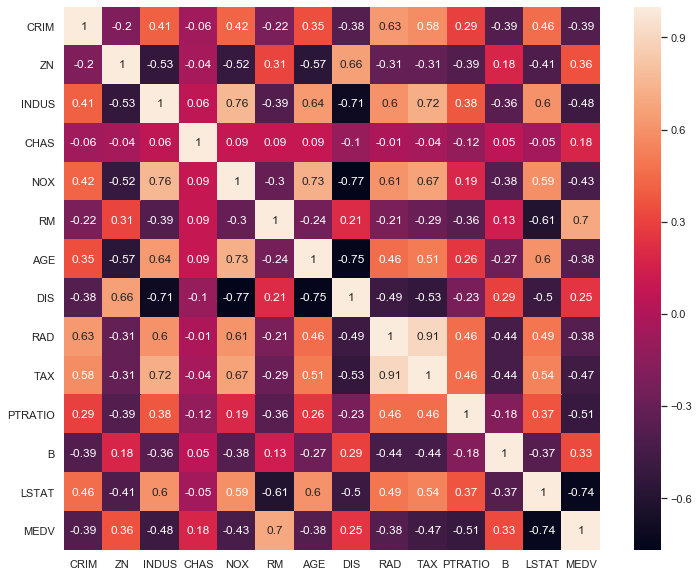

In [4]:
sns.set(rc={'figure.figsize':(12,10)})
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
correlation_matrix["MEDV"]

CRIM      -0.39
ZN         0.36
INDUS     -0.48
CHAS       0.18
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
B          0.33
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [6]:
cm = correlation_matrix.transform(func= lambda x: abs(x))["MEDV"].sort_values(ascending=False)
cm = cm.drop("MEDV",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
RAD        0.38
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

Because the TAX and RAD parameters are highly correlated (0.91) both should not be  used in training any model. As TAX has a higher correlation than RAD, the RAD feature will be dropped.

In [7]:
cm = cm.drop("RAD",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

In [8]:
# Putting all possible parameters in a list in order of correlation
params = []
for i in range(0, len(cm)):
    params.append(cm.index[i])

In [9]:
y = data['MEDV'] # outputs

def getInputs(noPar):
    # Split the dataset into what we are using
    return data[params[:noPar]] # inputs

In [10]:
def scaleDS(inputs):
    # Adding a scaler
    scaler = pre.StandardScaler()
    scaler.fit(inputs)
    return scaler.transform(inputs)

In [11]:
def splitDS(inputs):
    global x_train, x_test, y_train, y_test
    # Split the dataset into training and testing
    x_train, x_test, y_train, y_test = mod.train_test_split(inputs, y, test_size=testSize)

In [12]:
def createModel(actType, optType):
    global noParams, noEpoch, batchSize
    # Create our model
    m = kr.models.Sequential()
    m.add(kr.layers.Dense(20, input_dim=noParams, activation = actType))
    m.add(kr.layers.Dense(1, activation="linear"))
    m.compile(loss = "mean_squared_error", optimizer =optType)
    # Train the network
    m.fit(x_train, y_train, epochs=noEpoch, batch_size=batchSize)
    return m

In [13]:
def doModel(model, epo, bs):
    global x_trian, x_test, y_tran, y_test, batchSize
    # Train the network
    model.fit(x_train, y_train, epochs=epo, batch_size=bs)
    # Calculate the loss function (Mean squared error in our case)
    return model.evaluate(x_test, y_test)

In [14]:
# Headings for the data
results= []

In [34]:
# Parameterise everything

# Do you want to create and test all the models? 
# If yes, set the following to true, if no, leave at false and data from previous run will be read into dataframe
yesCreateModels = True

# No of variables to include in predictions
noParams = 4 

# Test / Train Split
testSize = 0.3

# All the activations
acts = ["relu", "tanh", "sigmoid", "exponential", "elu", "linear"]
#act = acts[5]

# Optimisers
opts= ["sgd", "adam", "nadam"]
opt = opts[2]

# model trial settings
noEpoch= 100
batchSize = 10

# Whether the data should be scaled or not
scaling = True

if yesCreateModels == True:
    # Check for increasing no of attributes and all activations
    for act in acts:
        for noParams in range(1,12):
            # Create your inputs
            x = getInputs(noParams)
            # Scale if it is called for
            if scaling  == False:
                x_scaled = scaleDS(x)
            else:
                x_scaled = x
            # Split into training and testing data
            splitDS(x_scaled)
            # Create the model based on the paramters supplied
            m = createModel(act, opt)
            # Append the settings and final loss results after fitting and evaluating the model to the results file
            results.append([noParams, scaling, testSize, act, opt, noEpoch, batchSize, doModel(m, noEpoch, batchSize)])

Epoch 1/100
354/354 [==============================] - 0s 622us/step - loss: 407.0318
Epoch 2/100
354/354 [==============================] - 0s 59us/step - loss: 339.7243
Epoch 3/100
354/354 [==============================] - 0s 70us/step - loss: 307.6393
Epoch 4/100
354/354 [==============================] - 0s 62us/step - loss: 297.8477
Epoch 5/100
354/354 [==============================] - 0s 75us/step - loss: 294.4653
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 291.6690
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 288.9008
Epoch 8/100
354/354 [==============================] - 0s 65us/step - loss: 285.8014
Epoch 9/100
354/354 [==============================] - 0s 70us/step - loss: 282.7311
Epoch 10/100
354/354 [==============================] - 0s 79us/step - loss: 279.6617
Epoch 11/100
354/354 [==============================] - 0s 65us/step - loss: 276.2450
Epoch 12/100
354/354 [==============================] - 0s 76u

Epoch 97/100
354/354 [==============================] - 0s 68us/step - loss: 34.5398
Epoch 98/100
354/354 [==============================] - 0s 70us/step - loss: 34.5526
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 34.6189
Epoch 100/100
354/354 [==============================] - ETA: 0s - loss: 20.45 - 0s 68us/step - loss: 34.3683
Epoch 1/100
354/354 [==============================] - 0s 70us/step - loss: 34.6287
Epoch 2/100
354/354 [==============================] - 0s 68us/step - loss: 34.7610
Epoch 3/100
354/354 [==============================] - 0s 68us/step - loss: 34.5258
Epoch 4/100
354/354 [==============================] - 0s 70us/step - loss: 34.4347
Epoch 5/100
354/354 [==============================] - ETA: 0s - loss: 11.45 - 0s 68us/step - loss: 34.4363
Epoch 6/100
354/354 [==============================] - 0s 68us/step - loss: 34.5452
Epoch 7/100
354/354 [==============================] - 0s 68us/step - loss: 34.4432
Epoch 8/100
354/354 [==

354/354 [==============================] - 0s 65us/step - loss: 34.1535
Epoch 93/100
354/354 [==============================] - 0s 73us/step - loss: 34.1754
Epoch 94/100
354/354 [==============================] - 0s 68us/step - loss: 34.2207
Epoch 95/100
354/354 [==============================] - 0s 70us/step - loss: 34.0915
Epoch 96/100
354/354 [==============================] - 0s 68us/step - loss: 34.0397
Epoch 97/100
354/354 [==============================] - 0s 73us/step - loss: 34.1366
Epoch 98/100
354/354 [==============================] - 0s 73us/step - loss: 34.2519
Epoch 99/100
354/354 [==============================] - 0s 85us/step - loss: 34.2447
Epoch 100/100
152/152 [==============================] - 0s 151us/step
Epoch 1/100
354/354 [==============================] - 0s 605us/step - loss: 555.7871
Epoch 2/100
354/354 [==============================] - 0s 56us/step - loss: 365.5071
Epoch 3/100
354/354 [==============================] - 0s 68us/step - loss: 266.9775
Epoch 

354/354 [==============================] - 0s 65us/step - loss: 24.8794
Epoch 88/100
354/354 [==============================] - 0s 70us/step - loss: 25.0124
Epoch 89/100
354/354 [==============================] - 0s 68us/step - loss: 24.9953
Epoch 90/100
354/354 [==============================] - 0s 68us/step - loss: 24.8047
Epoch 91/100
354/354 [==============================] - 0s 65us/step - loss: 24.8493
Epoch 92/100
354/354 [==============================] - 0s 68us/step - loss: 24.8108
Epoch 93/100
354/354 [==============================] - 0s 68us/step - loss: 25.0949
Epoch 94/100
354/354 [==============================] - 0s 70us/step - loss: 24.9605
Epoch 95/100
354/354 [==============================] - 0s 68us/step - loss: 24.9124
Epoch 96/100
354/354 [==============================] - 0s 73us/step - loss: 25.1848
Epoch 97/100
354/354 [==============================] - 0s 65us/step - loss: 24.9000
Epoch 98/100
354/354 [==============================] - 0s 90us/step - loss: 2

354/354 [==============================] - 0s 68us/step - loss: 24.9099
Epoch 84/100
354/354 [==============================] - 0s 70us/step - loss: 24.6869
Epoch 85/100
354/354 [==============================] - 0s 68us/step - loss: 24.8199
Epoch 86/100
354/354 [==============================] - 0s 69us/step - loss: 24.8130
Epoch 87/100
354/354 [==============================] - 0s 68us/step - loss: 24.8891
Epoch 88/100
354/354 [==============================] - 0s 68us/step - loss: 24.9112
Epoch 89/100
354/354 [==============================] - 0s 65us/step - loss: 24.8896
Epoch 90/100
354/354 [==============================] - 0s 67us/step - loss: 24.7989
Epoch 91/100
354/354 [==============================] - 0s 65us/step - loss: 24.8246
Epoch 92/100
354/354 [==============================] - 0s 67us/step - loss: 24.8004
Epoch 93/100
354/354 [==============================] - 0s 68us/step - loss: 24.5849
Epoch 94/100
354/354 [==============================] - 0s 71us/step - loss: 2

354/354 [==============================] - 0s 68us/step - loss: 24.0621
Epoch 79/100
354/354 [==============================] - 0s 67us/step - loss: 23.9285
Epoch 80/100
354/354 [==============================] - 0s 68us/step - loss: 24.0076
Epoch 81/100
354/354 [==============================] - 0s 68us/step - loss: 23.9170
Epoch 82/100
354/354 [==============================] - 0s 70us/step - loss: 23.8336
Epoch 83/100
354/354 [==============================] - 0s 68us/step - loss: 23.8021
Epoch 84/100
354/354 [==============================] - 0s 68us/step - loss: 23.8178
Epoch 85/100
354/354 [==============================] - ETA: 0s - loss: 13.89 - 0s 68us/step - loss: 23.6031
Epoch 86/100
354/354 [==============================] - 0s 70us/step - loss: 23.5555
Epoch 87/100
354/354 [==============================] - 0s 67us/step - loss: 23.5253
Epoch 88/100
354/354 [==============================] - 0s 70us/step - loss: 23.4762
Epoch 89/100
354/354 [==============================] 

354/354 [==============================] - 0s 87us/step - loss: 21.6529
Epoch 75/100
354/354 [==============================] - 0s 79us/step - loss: 21.5115
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 21.5846
Epoch 77/100
354/354 [==============================] - 0s 68us/step - loss: 21.5883
Epoch 78/100
354/354 [==============================] - 0s 68us/step - loss: 21.5115
Epoch 79/100
354/354 [==============================] - 0s 68us/step - loss: 21.5717
Epoch 80/100
354/354 [==============================] - 0s 68us/step - loss: 21.5770
Epoch 81/100
354/354 [==============================] - 0s 70us/step - loss: 21.7257
Epoch 82/100
354/354 [==============================] - 0s 70us/step - loss: 21.4206
Epoch 83/100
354/354 [==============================] - 0s 70us/step - loss: 21.6966
Epoch 84/100
354/354 [==============================] - 0s 68us/step - loss: 21.4670
Epoch 85/100
354/354 [==============================] - 0s 70us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 15.1625
Epoch 70/100
354/354 [==============================] - 0s 68us/step - loss: 15.1829
Epoch 71/100
354/354 [==============================] - 0s 68us/step - loss: 15.3141
Epoch 72/100
354/354 [==============================] - 0s 70us/step - loss: 15.2253
Epoch 73/100
354/354 [==============================] - 0s 68us/step - loss: 15.1122
Epoch 74/100
354/354 [==============================] - 0s 70us/step - loss: 15.2266
Epoch 75/100
354/354 [==============================] - 0s 71us/step - loss: 15.2556
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 15.0016
Epoch 77/100
354/354 [==============================] - 0s 65us/step - loss: 15.0796
Epoch 78/100
354/354 [==============================] - 0s 71us/step - loss: 14.9317
Epoch 79/100
354/354 [==============================] - 0s 62us/step - loss: 15.0166
Epoch 80/100
354/354 [==============================] - 0s 62us/step - loss: 1

354/354 [==============================] - 0s 70us/step - loss: 13.5867
Epoch 66/100
354/354 [==============================] - 0s 71us/step - loss: 13.4606
Epoch 67/100
354/354 [==============================] - 0s 68us/step - loss: 13.5926
Epoch 68/100
354/354 [==============================] - 0s 71us/step - loss: 13.5619
Epoch 69/100
354/354 [==============================] - 0s 71us/step - loss: 13.2881
Epoch 70/100
354/354 [==============================] - 0s 82us/step - loss: 13.7957
Epoch 71/100
354/354 [==============================] - 0s 70us/step - loss: 13.2896
Epoch 72/100
354/354 [==============================] - 0s 70us/step - loss: 13.4224
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 13.3858
Epoch 74/100
354/354 [==============================] - 0s 68us/step - loss: 13.3944
Epoch 75/100
354/354 [==============================] - 0s 70us/step - loss: 13.5147
Epoch 76/100
354/354 [==============================] - 0s 68us/step - loss: 1

354/354 [==============================] - 0s 68us/step - loss: 47.8818
Epoch 61/100
354/354 [==============================] - 0s 70us/step - loss: 46.6749
Epoch 62/100
354/354 [==============================] - 0s 68us/step - loss: 44.8028
Epoch 63/100
354/354 [==============================] - 0s 70us/step - loss: 44.8456
Epoch 64/100
354/354 [==============================] - 0s 76us/step - loss: 44.6738
Epoch 65/100
354/354 [==============================] - 0s 73us/step - loss: 44.6190
Epoch 66/100
354/354 [==============================] - 0s 73us/step - loss: 43.4625
Epoch 67/100
354/354 [==============================] - 0s 70us/step - loss: 44.4316
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 45.5916
Epoch 69/100
354/354 [==============================] - 0s 70us/step - loss: 43.8038
Epoch 70/100
354/354 [==============================] - 0s 68us/step - loss: 42.2140
Epoch 71/100
354/354 [==============================] - 0s 70us/step - loss: 4

354/354 [==============================] - 0s 70us/step - loss: 31.2232
Epoch 57/100
354/354 [==============================] - 0s 77us/step - loss: 30.6079
Epoch 58/100
354/354 [==============================] - 0s 68us/step - loss: 35.8486
Epoch 59/100
354/354 [==============================] - 0s 68us/step - loss: 32.2400
Epoch 60/100
354/354 [==============================] - 0s 70us/step - loss: 31.8609
Epoch 61/100
354/354 [==============================] - 0s 70us/step - loss: 30.4218
Epoch 62/100
354/354 [==============================] - 0s 70us/step - loss: 29.8057
Epoch 63/100
354/354 [==============================] - 0s 70us/step - loss: 31.3352
Epoch 64/100
354/354 [==============================] - 0s 68us/step - loss: 29.9045
Epoch 65/100
354/354 [==============================] - 0s 70us/step - loss: 29.8553
Epoch 66/100
354/354 [==============================] - 0s 70us/step - loss: 30.4000
Epoch 67/100
354/354 [==============================] - 0s 70us/step - loss: 2

354/354 [==============================] - 0s 65us/step - loss: 35.5973
Epoch 52/100
354/354 [==============================] - 0s 71us/step - loss: 36.7078
Epoch 53/100
354/354 [==============================] - 0s 70us/step - loss: 35.7096
Epoch 54/100
354/354 [==============================] - 0s 65us/step - loss: 36.3341
Epoch 55/100
354/354 [==============================] - 0s 70us/step - loss: 35.3804
Epoch 56/100
354/354 [==============================] - 0s 67us/step - loss: 35.6607
Epoch 57/100
354/354 [==============================] - 0s 73us/step - loss: 35.5819
Epoch 58/100
354/354 [==============================] - 0s 65us/step - loss: 36.3639
Epoch 59/100
354/354 [==============================] - 0s 68us/step - loss: 39.6452
Epoch 60/100
354/354 [==============================] - 0s 65us/step - loss: 35.9720
Epoch 61/100
354/354 [==============================] - 0s 73us/step - loss: 32.9935
Epoch 62/100
354/354 [==============================] - 0s 68us/step - loss: 3

354/354 [==============================] - 0s 68us/step - loss: 24.9629
Epoch 48/100
354/354 [==============================] - 0s 70us/step - loss: 24.0857
Epoch 49/100
354/354 [==============================] - 0s 68us/step - loss: 25.8993
Epoch 50/100
354/354 [==============================] - 0s 68us/step - loss: 23.1280
Epoch 51/100
354/354 [==============================] - 0s 70us/step - loss: 23.7459
Epoch 52/100
354/354 [==============================] - 0s 65us/step - loss: 24.2520
Epoch 53/100
354/354 [==============================] - ETA: 0s - loss: 16.19 - 0s 70us/step - loss: 22.9825
Epoch 54/100
354/354 [==============================] - 0s 70us/step - loss: 23.3832
Epoch 55/100
354/354 [==============================] - 0s 68us/step - loss: 24.8339
Epoch 56/100
354/354 [==============================] - 0s 65us/step - loss: 24.2183
Epoch 57/100
354/354 [==============================] - 0s 68us/step - loss: 25.5620
Epoch 58/100
354/354 [==============================] 

354/354 [==============================] - 0s 68us/step - loss: 53.8680
Epoch 43/100
354/354 [==============================] - 0s 73us/step - loss: 53.1279
Epoch 44/100
354/354 [==============================] - 0s 68us/step - loss: 52.0102
Epoch 45/100
354/354 [==============================] - 0s 67us/step - loss: 51.2034
Epoch 46/100
354/354 [==============================] - 0s 65us/step - loss: 51.0455
Epoch 47/100
354/354 [==============================] - 0s 65us/step - loss: 50.1564
Epoch 48/100
354/354 [==============================] - 0s 70us/step - loss: 49.1080
Epoch 49/100
354/354 [==============================] - 0s 68us/step - loss: 49.0359
Epoch 50/100
354/354 [==============================] - 0s 65us/step - loss: 48.3500
Epoch 51/100
354/354 [==============================] - 0s 70us/step - loss: 48.3208
Epoch 52/100
354/354 [==============================] - 0s 76us/step - loss: 47.3123
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 4

354/354 [==============================] - 0s 70us/step - loss: 27.5479
Epoch 39/100
354/354 [==============================] - 0s 73us/step - loss: 27.4057
Epoch 40/100
354/354 [==============================] - 0s 68us/step - loss: 26.7188
Epoch 41/100
354/354 [==============================] - 0s 70us/step - loss: 26.9976
Epoch 42/100
354/354 [==============================] - 0s 68us/step - loss: 26.9210
Epoch 43/100
354/354 [==============================] - 0s 70us/step - loss: 26.9972
Epoch 44/100
354/354 [==============================] - 0s 65us/step - loss: 26.5249
Epoch 45/100
354/354 [==============================] - 0s 70us/step - loss: 26.1275
Epoch 46/100
354/354 [==============================] - 0s 68us/step - loss: 26.5052
Epoch 47/100
354/354 [==============================] - 0s 70us/step - loss: 26.5048
Epoch 48/100
354/354 [==============================] - 0s 65us/step - loss: 26.2446
Epoch 49/100
354/354 [==============================] - 0s 70us/step - loss: 2

354/354 [==============================] - 0s 70us/step - loss: 42.9036
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 42.4709
Epoch 35/100
354/354 [==============================] - 0s 70us/step - loss: 42.1370
Epoch 36/100
354/354 [==============================] - 0s 68us/step - loss: 42.5138
Epoch 37/100
354/354 [==============================] - 0s 68us/step - loss: 41.6340
Epoch 38/100
354/354 [==============================] - 0s 67us/step - loss: 40.6851
Epoch 39/100
354/354 [==============================] - 0s 65us/step - loss: 42.1003
Epoch 40/100
354/354 [==============================] - 0s 70us/step - loss: 40.9195
Epoch 41/100
354/354 [==============================] - 0s 68us/step - loss: 40.7659
Epoch 42/100
354/354 [==============================] - 0s 69us/step - loss: 40.0040
Epoch 43/100
354/354 [==============================] - 0s 68us/step - loss: 43.0409
Epoch 44/100
354/354 [==============================] - 0s 70us/step - loss: 4

354/354 [==============================] - 0s 70us/step - loss: 30.9147
Epoch 30/100
354/354 [==============================] - 0s 76us/step - loss: 29.5886
Epoch 31/100
354/354 [==============================] - 0s 73us/step - loss: 31.1685
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 30.5252
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: 33.6773
Epoch 34/100
354/354 [==============================] - 0s 68us/step - loss: 30.2926
Epoch 35/100
354/354 [==============================] - 0s 70us/step - loss: 30.6831
Epoch 36/100
354/354 [==============================] - 0s 70us/step - loss: 30.2137
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: 30.5579
Epoch 38/100
354/354 [==============================] - 0s 73us/step - loss: 31.9088
Epoch 39/100
354/354 [==============================] - 0s 70us/step - loss: 29.4863
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 73us/step - loss: 36.6651
Epoch 25/100
354/354 [==============================] - 0s 70us/step - loss: 37.6809
Epoch 26/100
354/354 [==============================] - 0s 68us/step - loss: 36.6055
Epoch 27/100
354/354 [==============================] - 0s 68us/step - loss: 36.3487
Epoch 28/100
354/354 [==============================] - 0s 68us/step - loss: 36.2942
Epoch 29/100
354/354 [==============================] - 0s 68us/step - loss: 35.4336
Epoch 30/100
354/354 [==============================] - 0s 65us/step - loss: 33.8888
Epoch 31/100
354/354 [==============================] - 0s 71us/step - loss: 35.5033
Epoch 32/100
354/354 [==============================] - 0s 65us/step - loss: 34.4317
Epoch 33/100
354/354 [==============================] - 0s 68us/step - loss: 33.1670
Epoch 34/100
354/354 [==============================] - 0s 68us/step - loss: 33.7835
Epoch 35/100
354/354 [==============================] - 0s 70us/step - loss: 3

354/354 [==============================] - 0s 68us/step - loss: 18.3420
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: 17.7817
Epoch 22/100
354/354 [==============================] - 0s 70us/step - loss: 19.3445
Epoch 23/100
354/354 [==============================] - 0s 65us/step - loss: 19.6075
Epoch 24/100
354/354 [==============================] - 0s 62us/step - loss: 19.1463
Epoch 25/100
354/354 [==============================] - 0s 68us/step - loss: 18.4663
Epoch 26/100
354/354 [==============================] - 0s 70us/step - loss: 18.7902
Epoch 27/100
354/354 [==============================] - 0s 68us/step - loss: 18.2101
Epoch 28/100
354/354 [==============================] - 0s 65us/step - loss: 19.1350
Epoch 29/100
354/354 [==============================] - 0s 68us/step - loss: 19.2418
Epoch 30/100
354/354 [==============================] - 0s 65us/step - loss: 19.3632
Epoch 31/100
354/354 [==============================] - 0s 65us/step - loss: 1

354/354 [==============================] - 0s 68us/step - loss: 51.5209
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 49.3493
Epoch 17/100
354/354 [==============================] - 0s 70us/step - loss: 48.0655
Epoch 18/100
354/354 [==============================] - 0s 70us/step - loss: 47.0338
Epoch 19/100
354/354 [==============================] - 0s 65us/step - loss: 47.5729
Epoch 20/100
354/354 [==============================] - 0s 68us/step - loss: 46.2115
Epoch 21/100
354/354 [==============================] - 0s 68us/step - loss: 46.2945
Epoch 22/100
354/354 [==============================] - 0s 73us/step - loss: 45.4590
Epoch 23/100
354/354 [==============================] - 0s 65us/step - loss: 44.4194
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: 43.4388
Epoch 25/100
354/354 [==============================] - 0s 68us/step - loss: 41.8635
Epoch 26/100
354/354 [==============================] - 0s 70us/step - loss: 4

354/354 [==============================] - 0s 68us/step - loss: 35.9478
Epoch 12/100
354/354 [==============================] - 0s 73us/step - loss: 34.3544
Epoch 13/100
354/354 [==============================] - 0s 69us/step - loss: 34.7760
Epoch 14/100
354/354 [==============================] - 0s 71us/step - loss: 32.6960
Epoch 15/100
354/354 [==============================] - 0s 70us/step - loss: 42.1722
Epoch 16/100
354/354 [==============================] - 0s 70us/step - loss: 33.2946
Epoch 17/100
354/354 [==============================] - 0s 76us/step - loss: 32.5813
Epoch 18/100
354/354 [==============================] - 0s 70us/step - loss: 34.3819
Epoch 19/100
354/354 [==============================] - 0s 73us/step - loss: 38.0602
Epoch 20/100
354/354 [==============================] - 0s 65us/step - loss: 34.6462
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: 34.7676
Epoch 22/100
354/354 [==============================] - 0s 65us/step - loss: 3

354/354 [==============================] - 0s 68us/step - loss: 56.3071
Epoch 7/100
354/354 [==============================] - 0s 65us/step - loss: 55.8063
Epoch 8/100
354/354 [==============================] - 0s 62us/step - loss: 54.2791
Epoch 9/100
354/354 [==============================] - 0s 68us/step - loss: 52.2622
Epoch 10/100
354/354 [==============================] - 0s 62us/step - loss: 51.3551
Epoch 11/100
354/354 [==============================] - 0s 68us/step - loss: 50.5030
Epoch 12/100
354/354 [==============================] - 0s 68us/step - loss: 49.1162
Epoch 13/100
354/354 [==============================] - 0s 65us/step - loss: 48.0787
Epoch 14/100
354/354 [==============================] - 0s 70us/step - loss: 46.4207
Epoch 15/100
354/354 [==============================] - 0s 68us/step - loss: 48.0751
Epoch 16/100
354/354 [==============================] - 0s 70us/step - loss: 45.2500
Epoch 17/100
354/354 [==============================] - 0s 71us/step - loss: 45.2

354/354 [==============================] - 0s 72us/step - loss: 31.0482
Epoch 3/100
354/354 [==============================] - 0s 68us/step - loss: 29.5232
Epoch 4/100
354/354 [==============================] - 0s 76us/step - loss: 31.2031
Epoch 5/100
354/354 [==============================] - 0s 68us/step - loss: 31.2136
Epoch 6/100
354/354 [==============================] - 0s 71us/step - loss: 32.0811
Epoch 7/100
354/354 [==============================] - 0s 68us/step - loss: 29.7817
Epoch 8/100
354/354 [==============================] - 0s 73us/step - loss: 29.9543
Epoch 9/100
354/354 [==============================] - 0s 68us/step - loss: 30.1116
Epoch 10/100
354/354 [==============================] - 0s 77us/step - loss: 31.7917
Epoch 11/100
354/354 [==============================] - 0s 73us/step - loss: 30.5165
Epoch 12/100
354/354 [==============================] - 0s 68us/step - loss: 30.0586
Epoch 13/100
354/354 [==============================] - 0s 76us/step - loss: 29.8484


354/354 [==============================] - 0s 70us/step - loss: 24.6042
Epoch 99/100
354/354 [==============================] - 0s 70us/step - loss: 24.9710
Epoch 100/100
152/152 [==============================] - 0s 151us/step
Epoch 1/100
354/354 [==============================] - 0s 603us/step - loss: 618.3860
Epoch 2/100
354/354 [==============================] - 0s 59us/step - loss: 550.1371
Epoch 3/100
354/354 [==============================] - 0s 62us/step - loss: 487.1421
Epoch 4/100
354/354 [==============================] - 0s 65us/step - loss: 428.0257
Epoch 5/100
354/354 [==============================] - 0s 65us/step - loss: 370.7618
Epoch 6/100
354/354 [==============================] - 0s 65us/step - loss: 313.8481
Epoch 7/100
354/354 [==============================] - 0s 65us/step - loss: 275.4758
Epoch 8/100
354/354 [==============================] - 0s 65us/step - loss: 243.0331
Epoch 9/100
354/354 [==============================] - 0s 68us/step - loss: 215.3584
Epoch 

354/354 [==============================] - 0s 68us/step - loss: 81.5331
Epoch 94/100
354/354 [==============================] - 0s 73us/step - loss: 81.5520
Epoch 95/100
354/354 [==============================] - 0s 68us/step - loss: 81.5469
Epoch 96/100
354/354 [==============================] - 0s 65us/step - loss: 81.5929
Epoch 97/100
354/354 [==============================] - 0s 65us/step - loss: 81.5322
Epoch 98/100
354/354 [==============================] - 0s 68us/step - loss: 81.5768
Epoch 99/100
354/354 [==============================] - 0s 68us/step - loss: 81.5322
Epoch 100/100
354/354 [==============================] - 0s 70us/step - loss: 81.5557
Epoch 1/100
354/354 [==============================] - 0s 68us/step - loss: 81.5612
Epoch 2/100
354/354 [==============================] - 0s 73us/step - loss: 81.5270
Epoch 3/100
354/354 [==============================] - 0s 68us/step - loss: 81.5585
Epoch 4/100
354/354 [==============================] - 0s 73us/step - loss: 81.5

354/354 [==============================] - 0s 68us/step - loss: 81.4468
Epoch 90/100
354/354 [==============================] - 0s 82us/step - loss: 81.4110
Epoch 91/100
354/354 [==============================] - 0s 67us/step - loss: 81.4302
Epoch 92/100
354/354 [==============================] - 0s 68us/step - loss: 81.4183
Epoch 93/100
354/354 [==============================] - 0s 70us/step - loss: 81.4557
Epoch 94/100
354/354 [==============================] - ETA: 0s - loss: 28.08 - 0s 65us/step - loss: 81.4303
Epoch 95/100
354/354 [==============================] - 0s 71us/step - loss: 81.4660
Epoch 96/100
354/354 [==============================] - 0s 65us/step - loss: 81.4533
Epoch 97/100
354/354 [==============================] - 0s 73us/step - loss: 81.4481
Epoch 98/100
354/354 [==============================] - 0s 68us/step - loss: 81.4502
Epoch 99/100
354/354 [==============================] - 0s 71us/step - loss: 81.4691
Epoch 100/100
152/152 [==============================]

354/354 [==============================] - 0s 68us/step - loss: 27.5597
Epoch 85/100
354/354 [==============================] - 0s 76us/step - loss: 27.5255
Epoch 86/100
354/354 [==============================] - 0s 79us/step - loss: 27.3856
Epoch 87/100
354/354 [==============================] - 0s 76us/step - loss: 27.2276
Epoch 88/100
354/354 [==============================] - 0s 68us/step - loss: 27.1477
Epoch 89/100
354/354 [==============================] - 0s 65us/step - loss: 27.0176
Epoch 90/100
354/354 [==============================] - 0s 70us/step - loss: 26.9471
Epoch 91/100
354/354 [==============================] - 0s 68us/step - loss: 26.8513
Epoch 92/100
354/354 [==============================] - 0s 68us/step - loss: 26.8621
Epoch 93/100
354/354 [==============================] - 0s 62us/step - loss: 26.5961
Epoch 94/100
354/354 [==============================] - 0s 65us/step - loss: 26.5065
Epoch 95/100
354/354 [==============================] - 0s 68us/step - loss: 2

354/354 [==============================] - 0s 70us/step - loss: 23.2136
Epoch 81/100
354/354 [==============================] - 0s 73us/step - loss: 23.3194
Epoch 82/100
354/354 [==============================] - 0s 67us/step - loss: 23.2573
Epoch 83/100
354/354 [==============================] - 0s 68us/step - loss: 23.1721
Epoch 84/100
354/354 [==============================] - 0s 65us/step - loss: 23.3550
Epoch 85/100
354/354 [==============================] - 0s 70us/step - loss: 23.2175
Epoch 86/100
354/354 [==============================] - 0s 68us/step - loss: 23.1606
Epoch 87/100
354/354 [==============================] - 0s 68us/step - loss: 23.1598
Epoch 88/100
354/354 [==============================] - 0s 65us/step - loss: 23.1412
Epoch 89/100
354/354 [==============================] - 0s 65us/step - loss: 23.1236
Epoch 90/100
354/354 [==============================] - 0s 70us/step - loss: 23.1207
Epoch 91/100
354/354 [==============================] - 0s 68us/step - loss: 2

354/354 [==============================] - 0s 71us/step - loss: 28.1267
Epoch 76/100
354/354 [==============================] - 0s 71us/step - loss: 27.9248
Epoch 77/100
354/354 [==============================] - 0s 70us/step - loss: 27.7603
Epoch 78/100
354/354 [==============================] - 0s 70us/step - loss: 27.5711
Epoch 79/100
354/354 [==============================] - 0s 73us/step - loss: 27.2253
Epoch 80/100
354/354 [==============================] - 0s 73us/step - loss: 27.1360
Epoch 81/100
354/354 [==============================] - 0s 72us/step - loss: 26.8548
Epoch 82/100
354/354 [==============================] - 0s 65us/step - loss: 26.8666
Epoch 83/100
354/354 [==============================] - 0s 73us/step - loss: 26.5757
Epoch 84/100
354/354 [==============================] - 0s 65us/step - loss: 26.4941
Epoch 85/100
354/354 [==============================] - 0s 70us/step - loss: 26.3080
Epoch 86/100
354/354 [==============================] - 0s 65us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 20.1386
Epoch 72/100
354/354 [==============================] - 0s 76us/step - loss: 20.0856
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 20.1514
Epoch 74/100
354/354 [==============================] - 0s 70us/step - loss: 20.1035
Epoch 75/100
354/354 [==============================] - 0s 71us/step - loss: 20.0317
Epoch 76/100
354/354 [==============================] - 0s 70us/step - loss: 19.9559
Epoch 77/100
354/354 [==============================] - 0s 68us/step - loss: 19.9609
Epoch 78/100
354/354 [==============================] - 0s 68us/step - loss: 19.9215
Epoch 79/100
354/354 [==============================] - 0s 70us/step - loss: 19.8389
Epoch 80/100
354/354 [==============================] - 0s 68us/step - loss: 20.0134
Epoch 81/100
354/354 [==============================] - 0s 73us/step - loss: 19.7857
Epoch 82/100
354/354 [==============================] - 0s 65us/step - loss: 1

354/354 [==============================] - 0s 76us/step - loss: 33.8426
Epoch 67/100
354/354 [==============================] - 0s 73us/step - loss: 33.4211
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 33.0052
Epoch 69/100
354/354 [==============================] - 0s 70us/step - loss: 32.8450
Epoch 70/100
354/354 [==============================] - 0s 73us/step - loss: 32.6238
Epoch 71/100
354/354 [==============================] - 0s 73us/step - loss: 32.2640
Epoch 72/100
354/354 [==============================] - 0s 73us/step - loss: 31.8424
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 31.5380
Epoch 74/100
354/354 [==============================] - 0s 73us/step - loss: 31.2568
Epoch 75/100
354/354 [==============================] - 0s 70us/step - loss: 30.8682
Epoch 76/100
354/354 [==============================] - 0s 73us/step - loss: 28.3494
Epoch 77/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 70us/step - loss: 18.3631
Epoch 63/100
354/354 [==============================] - 0s 73us/step - loss: 18.0876
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 18.1601
Epoch 65/100
354/354 [==============================] - 0s 71us/step - loss: 18.1547
Epoch 66/100
354/354 [==============================] - 0s 73us/step - loss: 18.2659
Epoch 67/100
354/354 [==============================] - 0s 70us/step - loss: 18.2462
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 18.2532
Epoch 69/100
354/354 [==============================] - 0s 70us/step - loss: 18.1004
Epoch 70/100
354/354 [==============================] - 0s 68us/step - loss: 17.9950
Epoch 71/100
354/354 [==============================] - 0s 68us/step - loss: 17.7736
Epoch 72/100
354/354 [==============================] - 0s 73us/step - loss: 18.1384
Epoch 73/100
354/354 [==============================] - 0s 68us/step - loss: 1

354/354 [==============================] - 0s 65us/step - loss: 80.5349
Epoch 58/100
354/354 [==============================] - 0s 70us/step - loss: 80.5106
Epoch 59/100
354/354 [==============================] - 0s 65us/step - loss: 80.5084
Epoch 60/100
354/354 [==============================] - 0s 70us/step - loss: 80.5192
Epoch 61/100
354/354 [==============================] - 0s 65us/step - loss: 80.5428
Epoch 62/100
354/354 [==============================] - 0s 70us/step - loss: 80.5156
Epoch 63/100
354/354 [==============================] - 0s 65us/step - loss: 80.5377
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 80.5037
Epoch 65/100
354/354 [==============================] - 0s 68us/step - loss: 80.5116
Epoch 66/100
354/354 [==============================] - 0s 70us/step - loss: 80.5364
Epoch 67/100
354/354 [==============================] - 0s 65us/step - loss: 80.5196
Epoch 68/100
354/354 [==============================] - 0s 70us/step - loss: 8

354/354 [==============================] - 0s 71us/step - loss: 80.6244
Epoch 54/100
354/354 [==============================] - 0s 73us/step - loss: 80.4617
Epoch 55/100
354/354 [==============================] - 0s 76us/step - loss: 80.4496
Epoch 56/100
354/354 [==============================] - 0s 70us/step - loss: 80.4297
Epoch 57/100
354/354 [==============================] - 0s 69us/step - loss: 80.4720
Epoch 58/100
354/354 [==============================] - 0s 70us/step - loss: 80.4760
Epoch 59/100
354/354 [==============================] - 0s 68us/step - loss: 80.4438
Epoch 60/100
354/354 [==============================] - 0s 70us/step - loss: 80.4919
Epoch 61/100
354/354 [==============================] - 0s 68us/step - loss: 80.4873
Epoch 62/100
354/354 [==============================] - 0s 70us/step - loss: 80.4357
Epoch 63/100
354/354 [==============================] - 0s 68us/step - loss: 80.4624
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 8

354/354 [==============================] - 0s 86us/step - loss: 76.5964
Epoch 48/100
354/354 [==============================] - 0s 85us/step - loss: 75.9723
Epoch 49/100
354/354 [==============================] - 0s 79us/step - loss: 75.1960
Epoch 50/100
354/354 [==============================] - 0s 75us/step - loss: 74.5436
Epoch 51/100
354/354 [==============================] - 0s 73us/step - loss: 73.8475
Epoch 52/100
354/354 [==============================] - 0s 73us/step - loss: 73.6571
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 73.3806
Epoch 54/100
354/354 [==============================] - 0s 73us/step - loss: 73.0173
Epoch 55/100
354/354 [==============================] - 0s 73us/step - loss: 72.0353
Epoch 56/100
354/354 [==============================] - 0s 73us/step - loss: 71.3931
Epoch 57/100
354/354 [==============================] - 0s 73us/step - loss: 72.7830
Epoch 58/100
354/354 [==============================] - 0s 68us/step - loss: 7

354/354 [==============================] - 0s 73us/step - loss: 48.1847
Epoch 44/100
354/354 [==============================] - 0s 70us/step - loss: 48.0207
Epoch 45/100
354/354 [==============================] - 0s 73us/step - loss: 47.7302
Epoch 46/100
354/354 [==============================] - 0s 73us/step - loss: 47.5019
Epoch 47/100
354/354 [==============================] - 0s 68us/step - loss: 47.6369
Epoch 48/100
354/354 [==============================] - 0s 73us/step - loss: 47.4214
Epoch 49/100
354/354 [==============================] - 0s 70us/step - loss: 49.3663
Epoch 50/100
354/354 [==============================] - 0s 68us/step - loss: 47.8054
Epoch 51/100
354/354 [==============================] - 0s 70us/step - loss: 48.5539
Epoch 52/100
354/354 [==============================] - 0s 73us/step - loss: 47.3890
Epoch 53/100
354/354 [==============================] - 0s 71us/step - loss: 46.5415
Epoch 54/100
354/354 [==============================] - 0s 73us/step - loss: 4

354/354 [==============================] - 0s 73us/step - loss: 80.0341
Epoch 39/100
354/354 [==============================] - 0s 79us/step - loss: 80.0275
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 80.0218
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 80.0170
Epoch 42/100
354/354 [==============================] - 0s 78us/step - loss: 80.0207
Epoch 43/100
354/354 [==============================] - 0s 68us/step - loss: 80.0071
Epoch 44/100
354/354 [==============================] - 0s 82us/step - loss: 80.0410
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 80.0114
Epoch 46/100
354/354 [==============================] - 0s 72us/step - loss: 80.0149
Epoch 47/100
354/354 [==============================] - 0s 70us/step - loss: 80.0367
Epoch 48/100
354/354 [==============================] - 0s 71us/step - loss: 80.0264
Epoch 49/100
354/354 [==============================] - 0s 70us/step - loss: 8

354/354 [==============================] - 0s 76us/step - loss: 80.0366
Epoch 35/100
354/354 [==============================] - 0s 70us/step - loss: 80.0417
Epoch 36/100
354/354 [==============================] - 0s 70us/step - loss: 80.0366
Epoch 37/100
354/354 [==============================] - 0s 65us/step - loss: 80.0395
Epoch 38/100
354/354 [==============================] - 0s 70us/step - loss: 80.0587
Epoch 39/100
354/354 [==============================] - 0s 65us/step - loss: 80.0390
Epoch 40/100
354/354 [==============================] - 0s 70us/step - loss: 80.0441
Epoch 41/100
354/354 [==============================] - 0s 65us/step - loss: 80.1351
Epoch 42/100
354/354 [==============================] - 0s 70us/step - loss: 80.0527
Epoch 43/100
354/354 [==============================] - 0s 68us/step - loss: 80.0381
Epoch 44/100
354/354 [==============================] - 0s 68us/step - loss: 80.0418
Epoch 45/100
354/354 [==============================] - 0s 65us/step - loss: 8

354/354 [==============================] - 0s 70us/step - loss: 84.7873
Epoch 30/100
354/354 [==============================] - 0s 70us/step - loss: 84.6965
Epoch 31/100
354/354 [==============================] - 0s 71us/step - loss: 84.6393
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 84.5937
Epoch 33/100
354/354 [==============================] - 0s 76us/step - loss: 84.5738
Epoch 34/100
354/354 [==============================] - 0s 70us/step - loss: 84.5519
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: 84.5633
Epoch 36/100
354/354 [==============================] - 0s 73us/step - loss: 84.5446
Epoch 37/100
354/354 [==============================] - 0s 68us/step - loss: 84.5169
Epoch 38/100
354/354 [==============================] - 0s 68us/step - loss: 84.5219
Epoch 39/100
354/354 [==============================] - 0s 66us/step - loss: 84.5218
Epoch 40/100
354/354 [==============================] - 0s 73us/step - loss: 8

354/354 [==============================] - 0s 72us/step - loss: 84.4303
Epoch 26/100
354/354 [==============================] - 0s 73us/step - loss: 84.4331
Epoch 27/100
354/354 [==============================] - 0s 73us/step - loss: 84.4467
Epoch 28/100
354/354 [==============================] - 0s 70us/step - loss: 84.4391
Epoch 29/100
354/354 [==============================] - 0s 79us/step - loss: 84.4552
Epoch 30/100
354/354 [==============================] - 0s 70us/step - loss: 84.4543
Epoch 31/100
354/354 [==============================] - 0s 67us/step - loss: 84.4463
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 84.4609
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: 84.4423
Epoch 34/100
354/354 [==============================] - 0s 68us/step - loss: 84.4239
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: 84.5160
Epoch 36/100
354/354 [==============================] - 0s 76us/step - loss: 8

354/354 [==============================] - 0s 79us/step - loss: 92.8465
Epoch 21/100
354/354 [==============================] - 0s 59us/step - loss: 91.7099
Epoch 22/100
354/354 [==============================] - 0s 65us/step - loss: 90.8730
Epoch 23/100
354/354 [==============================] - 0s 62us/step - loss: 90.2436
Epoch 24/100
354/354 [==============================] - 0s 59us/step - loss: 89.8406
Epoch 25/100
354/354 [==============================] - 0s 71us/step - loss: 89.4750
Epoch 26/100
354/354 [==============================] - 0s 65us/step - loss: 89.2132
Epoch 27/100
354/354 [==============================] - 0s 68us/step - loss: 89.0314
Epoch 28/100
354/354 [==============================] - 0s 65us/step - loss: 88.9512
Epoch 29/100
354/354 [==============================] - 0s 65us/step - loss: 88.8118
Epoch 30/100
354/354 [==============================] - 0s 62us/step - loss: 87.6555
Epoch 31/100
354/354 [==============================] - 0s 68us/step - loss: 8

354/354 [==============================] - 0s 73us/step - loss: 87.5912
Epoch 17/100
354/354 [==============================] - 0s 73us/step - loss: 87.5533
Epoch 18/100
354/354 [==============================] - 0s 73us/step - loss: 87.5723
Epoch 19/100
354/354 [==============================] - 0s 68us/step - loss: 87.5413
Epoch 20/100
354/354 [==============================] - 0s 73us/step - loss: 87.5722
Epoch 21/100
354/354 [==============================] - 0s 68us/step - loss: 87.5597
Epoch 22/100
354/354 [==============================] - 0s 73us/step - loss: 87.5340
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: 87.6315
Epoch 24/100
354/354 [==============================] - 0s 70us/step - loss: 87.5512
Epoch 25/100
354/354 [==============================] - 0s 73us/step - loss: 87.6601
Epoch 26/100
354/354 [==============================] - 0s 68us/step - loss: 87.6047
Epoch 27/100
354/354 [==============================] - 0s 73us/step - loss: 8

354/354 [==============================] - 0s 68us/step - loss: 192.1485
Epoch 12/100
354/354 [==============================] - 0s 73us/step - loss: 172.6668
Epoch 13/100
354/354 [==============================] - 0s 70us/step - loss: 156.0846
Epoch 14/100
354/354 [==============================] - 0s 79us/step - loss: 141.7673
Epoch 15/100
354/354 [==============================] - 0s 73us/step - loss: 129.5303
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 119.3638
Epoch 17/100
354/354 [==============================] - 0s 76us/step - loss: 110.8276
Epoch 18/100
354/354 [==============================] - 0s 68us/step - loss: 103.5075
Epoch 19/100
354/354 [==============================] - 0s 73us/step - loss: 97.6763
Epoch 20/100
354/354 [==============================] - 0s 71us/step - loss: 92.7547
Epoch 21/100
354/354 [==============================] - 0s 68us/step - loss: 88.0411
Epoch 22/100
354/354 [==============================] - 0s 70us/step -

354/354 [==============================] - 0s 73us/step - loss: 57.4973
Epoch 8/100
354/354 [==============================] - 0s 76us/step - loss: 56.7819
Epoch 9/100
354/354 [==============================] - 0s 73us/step - loss: 56.8991
Epoch 10/100
354/354 [==============================] - 0s 73us/step - loss: 58.0958
Epoch 11/100
354/354 [==============================] - 0s 76us/step - loss: 56.7172
Epoch 12/100
354/354 [==============================] - 0s 73us/step - loss: 56.6783
Epoch 13/100
354/354 [==============================] - 0s 82us/step - loss: 56.8093
Epoch 14/100
354/354 [==============================] - 0s 76us/step - loss: 56.7409
Epoch 15/100
354/354 [==============================] - 0s 70us/step - loss: 56.5083
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 56.5918
Epoch 17/100
354/354 [==============================] - 0s 70us/step - loss: 56.6178
Epoch 18/100
354/354 [==============================] - 0s 68us/step - loss: 56.

354/354 [==============================] - 0s 59us/step - loss: 512.5536
Epoch 3/100
354/354 [==============================] - 0s 65us/step - loss: 455.1657
Epoch 4/100
354/354 [==============================] - 0s 70us/step - loss: 404.7110
Epoch 5/100
354/354 [==============================] - 0s 65us/step - loss: 357.9782
Epoch 6/100
354/354 [==============================] - 0s 68us/step - loss: 316.8352
Epoch 7/100
354/354 [==============================] - 0s 70us/step - loss: 281.2635
Epoch 8/100
354/354 [==============================] - 0s 70us/step - loss: 250.3570
Epoch 9/100
354/354 [==============================] - 0s 69us/step - loss: 223.5875
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 200.3910
Epoch 11/100
354/354 [==============================] - 0s 68us/step - loss: 180.4660
Epoch 12/100
354/354 [==============================] - 0s 70us/step - loss: 163.2761
Epoch 13/100
354/354 [==============================] - 0s 71us/step - los

354/354 [==============================] - 0s 73us/step - loss: 70.8576
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 70.7631
Epoch 100/100
354/354 [==============================] - 0s 73us/step - loss: 70.7125
Epoch 1/100
354/354 [==============================] - 0s 79us/step - loss: 70.6940
Epoch 2/100
354/354 [==============================] - 0s 73us/step - loss: 70.6707
Epoch 3/100
354/354 [==============================] - 0s 79us/step - loss: 70.6243
Epoch 4/100
354/354 [==============================] - 0s 76us/step - loss: 70.5812
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 70.5560
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 70.5361
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 70.5528
Epoch 8/100
354/354 [==============================] - 0s 85us/step - loss: 70.4769
Epoch 9/100
354/354 [==============================] - 0s 70us/step - loss: 70.4571
E

354/354 [==============================] - 0s 82us/step - loss: 67.4939
Epoch 95/100
354/354 [==============================] - 0s 76us/step - loss: 69.1956
Epoch 96/100
354/354 [==============================] - 0s 85us/step - loss: 69.8092
Epoch 97/100
354/354 [==============================] - 0s 73us/step - loss: 66.2185
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 69.5996
Epoch 99/100
354/354 [==============================] - 0s 80us/step - loss: 68.0361
Epoch 100/100
152/152 [==============================] - 0s 157us/step
Epoch 1/100
354/354 [==============================] - 0s 631us/step - loss: 549.3428
Epoch 2/100
354/354 [==============================] - 0s 65us/step - loss: 498.8528
Epoch 3/100
354/354 [==============================] - 0s 65us/step - loss: 439.6868
Epoch 4/100
354/354 [==============================] - 0s 65us/step - loss: 372.1274
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 307.3906
Epoch 

354/354 [==============================] - 0s 73us/step - loss: 62.2380
Epoch 90/100
354/354 [==============================] - 0s 76us/step - loss: 61.8246
Epoch 91/100
354/354 [==============================] - 0s 76us/step - loss: 61.4076
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 60.9815
Epoch 93/100
354/354 [==============================] - 0s 73us/step - loss: 60.5472
Epoch 94/100
354/354 [==============================] - 0s 70us/step - loss: 60.1679
Epoch 95/100
354/354 [==============================] - 0s 76us/step - loss: 59.7433
Epoch 96/100
354/354 [==============================] - 0s 70us/step - loss: 59.4082
Epoch 97/100
354/354 [==============================] - 0s 73us/step - loss: 58.9263
Epoch 98/100
354/354 [==============================] - 0s 82us/step - loss: 58.5660
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 58.1885
Epoch 100/100
354/354 [==============================] - 0s 79us/step - loss: 

354/354 [==============================] - 0s 73us/step - loss: 40.6169
Epoch 86/100
354/354 [==============================] - 0s 76us/step - loss: 40.4905
Epoch 87/100
354/354 [==============================] - 0s 73us/step - loss: 40.3745
Epoch 88/100
354/354 [==============================] - 0s 73us/step - loss: 40.3328
Epoch 89/100
354/354 [==============================] - 0s 73us/step - loss: 40.1535
Epoch 90/100
354/354 [==============================] - 0s 76us/step - loss: 40.0598
Epoch 91/100
354/354 [==============================] - 0s 85us/step - loss: 40.0109
Epoch 92/100
354/354 [==============================] - 0s 87us/step - loss: 39.8492
Epoch 93/100
354/354 [==============================] - 0s 85us/step - loss: 39.7721
Epoch 94/100
354/354 [==============================] - 0s 76us/step - loss: 39.6467
Epoch 95/100
354/354 [==============================] - 0s 76us/step - loss: 39.5673
Epoch 96/100
354/354 [==============================] - 0s 73us/step - loss: 3

354/354 [==============================] - 0s 82us/step - loss: 48.9512
Epoch 81/100
354/354 [==============================] - 0s 76us/step - loss: 48.6248
Epoch 82/100
354/354 [==============================] - 0s 76us/step - loss: 48.2833
Epoch 83/100
354/354 [==============================] - 0s 85us/step - loss: 47.9471
Epoch 84/100
354/354 [==============================] - 0s 76us/step - loss: 47.6351
Epoch 85/100
354/354 [==============================] - 0s 73us/step - loss: 47.4125
Epoch 86/100
354/354 [==============================] - 0s 73us/step - loss: 47.0583
Epoch 87/100
354/354 [==============================] - 0s 73us/step - loss: 46.7520
Epoch 88/100
354/354 [==============================] - 0s 70us/step - loss: 46.3792
Epoch 89/100
354/354 [==============================] - 0s 70us/step - loss: 46.0677
Epoch 90/100
354/354 [==============================] - 0s 82us/step - loss: 45.7463
Epoch 91/100
354/354 [==============================] - 0s 70us/step - loss: 4

354/354 [==============================] - 0s 71us/step - loss: 28.5261
Epoch 77/100
354/354 [==============================] - 0s 70us/step - loss: 28.5070
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 28.4890
Epoch 79/100
354/354 [==============================] - 0s 73us/step - loss: 28.3304
Epoch 80/100
354/354 [==============================] - 0s 73us/step - loss: 28.2927
Epoch 81/100
354/354 [==============================] - 0s 73us/step - loss: 28.1890
Epoch 82/100
354/354 [==============================] - 0s 70us/step - loss: 28.1877
Epoch 83/100
354/354 [==============================] - 0s 70us/step - loss: 28.1415
Epoch 84/100
354/354 [==============================] - 0s 70us/step - loss: 28.0763
Epoch 85/100
354/354 [==============================] - 0s 73us/step - loss: 27.9145
Epoch 86/100
354/354 [==============================] - 0s 76us/step - loss: 27.9720
Epoch 87/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 47.4185
Epoch 72/100
354/354 [==============================] - 0s 78us/step - loss: 46.8092
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 46.3573
Epoch 74/100
354/354 [==============================] - 0s 70us/step - loss: 45.9888
Epoch 75/100
354/354 [==============================] - 0s 73us/step - loss: 45.6360
Epoch 76/100
354/354 [==============================] - 0s 73us/step - loss: 45.1998
Epoch 77/100
354/354 [==============================] - 0s 70us/step - loss: 44.7947
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 44.4639
Epoch 79/100
354/354 [==============================] - 0s 76us/step - loss: 44.0576
Epoch 80/100
354/354 [==============================] - 0s 76us/step - loss: 43.6960
Epoch 81/100
354/354 [==============================] - 0s 73us/step - loss: 43.4123
Epoch 82/100
354/354 [==============================] - 0s 76us/step - loss: 4

354/354 [==============================] - 0s 76us/step - loss: 27.7219
Epoch 68/100
354/354 [==============================] - 0s 76us/step - loss: 27.5413
Epoch 69/100
354/354 [==============================] - 0s 82us/step - loss: 27.6227
Epoch 70/100
354/354 [==============================] - 0s 76us/step - loss: 27.4948
Epoch 71/100
354/354 [==============================] - 0s 73us/step - loss: 27.5235
Epoch 72/100
354/354 [==============================] - 0s 76us/step - loss: 27.3468
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 27.2245
Epoch 74/100
354/354 [==============================] - 0s 77us/step - loss: 27.1706
Epoch 75/100
354/354 [==============================] - 0s 73us/step - loss: 27.2042
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 27.1184
Epoch 77/100
354/354 [==============================] - 0s 73us/step - loss: 26.9509
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 70us/step - loss: 53.6513
Epoch 63/100
354/354 [==============================] - 0s 73us/step - loss: 53.1202
Epoch 64/100
354/354 [==============================] - 0s 76us/step - loss: 52.5576
Epoch 65/100
354/354 [==============================] - 0s 76us/step - loss: 52.0055
Epoch 66/100
354/354 [==============================] - 0s 76us/step - loss: 51.5460
Epoch 67/100
354/354 [==============================] - 0s 73us/step - loss: 51.0031
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 50.5585
Epoch 69/100
354/354 [==============================] - 0s 73us/step - loss: 50.0400
Epoch 70/100
354/354 [==============================] - 0s 70us/step - loss: 49.7213
Epoch 71/100
354/354 [==============================] - 0s 70us/step - loss: 49.2135
Epoch 72/100
354/354 [==============================] - 0s 71us/step - loss: 48.8014
Epoch 73/100
354/354 [==============================] - 0s 70us/step - loss: 4

354/354 [==============================] - 0s 70us/step - loss: 27.2408
Epoch 59/100
354/354 [==============================] - 0s 73us/step - loss: 27.1579
Epoch 60/100
354/354 [==============================] - 0s 70us/step - loss: 26.9237
Epoch 61/100
354/354 [==============================] - 0s 73us/step - loss: 26.8701
Epoch 62/100
354/354 [==============================] - 0s 73us/step - loss: 26.7402
Epoch 63/100
354/354 [==============================] - 0s 73us/step - loss: 26.5766
Epoch 64/100
354/354 [==============================] - 0s 85us/step - loss: 26.4485
Epoch 65/100
354/354 [==============================] - 0s 73us/step - loss: 26.3691
Epoch 66/100
354/354 [==============================] - 0s 76us/step - loss: 26.2410
Epoch 67/100
354/354 [==============================] - 0s 73us/step - loss: 26.3107
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 25.9844
Epoch 69/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 93us/step - loss: 78.7776
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 77.5691
Epoch 55/100
354/354 [==============================] - 0s 76us/step - loss: 76.8829
Epoch 56/100
354/354 [==============================] - 0s 70us/step - loss: 76.1351
Epoch 57/100
354/354 [==============================] - 0s 74us/step - loss: 75.9098
Epoch 58/100
354/354 [==============================] - 0s 73us/step - loss: 75.5504
Epoch 59/100
354/354 [==============================] - 0s 70us/step - loss: 75.1685
Epoch 60/100
354/354 [==============================] - 0s 73us/step - loss: 74.8839
Epoch 61/100
354/354 [==============================] - 0s 74us/step - loss: 74.4880
Epoch 62/100
354/354 [==============================] - 0s 70us/step - loss: 74.4727
Epoch 63/100
354/354 [==============================] - 0s 70us/step - loss: 74.0492
Epoch 64/100
354/354 [==============================] - 0s 70us/step - loss: 7

354/354 [==============================] - 0s 76us/step - loss: 46.5240
Epoch 50/100
354/354 [==============================] - 0s 79us/step - loss: 47.4185
Epoch 51/100
354/354 [==============================] - 0s 73us/step - loss: 46.4521
Epoch 52/100
354/354 [==============================] - 0s 79us/step - loss: 46.7017
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 45.9079
Epoch 54/100
354/354 [==============================] - 0s 68us/step - loss: 45.9177
Epoch 55/100
354/354 [==============================] - 0s 70us/step - loss: 46.0276
Epoch 56/100
354/354 [==============================] - 0s 70us/step - loss: 45.4624
Epoch 57/100
354/354 [==============================] - 0s 71us/step - loss: 45.5591
Epoch 58/100
354/354 [==============================] - 0s 70us/step - loss: 45.1864
Epoch 59/100
354/354 [==============================] - 0s 73us/step - loss: 44.9861
Epoch 60/100
354/354 [==============================] - 0s 70us/step - loss: 4

354/354 [==============================] - 0s 73us/step - loss: 81.9091
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 81.7938
Epoch 46/100
354/354 [==============================] - 0s 76us/step - loss: 81.6940
Epoch 47/100
354/354 [==============================] - 0s 73us/step - loss: 81.6159
Epoch 48/100
354/354 [==============================] - 0s 73us/step - loss: 81.5623
Epoch 49/100
354/354 [==============================] - 0s 73us/step - loss: 81.5163
Epoch 50/100
354/354 [==============================] - 0s 71us/step - loss: 81.4878
Epoch 51/100
354/354 [==============================] - 0s 73us/step - loss: 81.4526
Epoch 52/100
354/354 [==============================] - 0s 73us/step - loss: 81.4332
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 81.4040
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 81.4004
Epoch 55/100
354/354 [==============================] - 0s 76us/step - loss: 8

354/354 [==============================] - 0s 73us/step - loss: 81.3812
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 81.3756
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: 81.3553
Epoch 43/100
354/354 [==============================] - 0s 73us/step - loss: 81.3890
Epoch 44/100
354/354 [==============================] - 0s 70us/step - loss: 81.4454
Epoch 45/100
354/354 [==============================] - 0s 73us/step - loss: 81.3475
Epoch 46/100
354/354 [==============================] - 0s 71us/step - loss: 81.3792
Epoch 47/100
354/354 [==============================] - 0s 79us/step - loss: 81.3600
Epoch 48/100
354/354 [==============================] - 0s 70us/step - loss: 81.3602
Epoch 49/100
354/354 [==============================] - 0s 76us/step - loss: 81.4076
Epoch 50/100
354/354 [==============================] - 0s 76us/step - loss: 81.4216
Epoch 51/100
354/354 [==============================] - 0s 73us/step - loss: 8

354/354 [==============================] - 0s 76us/step - loss: 104.6866
Epoch 36/100
354/354 [==============================] - 0s 76us/step - loss: 102.6420
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 100.8396
Epoch 38/100
354/354 [==============================] - 0s 74us/step - loss: 99.2518
Epoch 39/100
354/354 [==============================] - 0s 79us/step - loss: 97.7643
Epoch 40/100
354/354 [==============================] - 0s 79us/step - loss: 96.4478
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 95.4178
Epoch 42/100
354/354 [==============================] - ETA: 0s - loss: 24.17 - 0s 76us/step - loss: 94.4134
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 93.6428
Epoch 44/100
354/354 [==============================] - 0s 76us/step - loss: 92.9085
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 92.3021
Epoch 46/100
354/354 [=============================

354/354 [==============================] - 0s 76us/step - loss: 47.2445
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 46.9425
Epoch 33/100
354/354 [==============================] - 0s 76us/step - loss: 47.3169
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 46.6379
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: 46.3726
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 46.1659
Epoch 37/100
354/354 [==============================] - 0s 72us/step - loss: 45.7615
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: 45.5482
Epoch 39/100
354/354 [==============================] - 0s 76us/step - loss: 45.6707
Epoch 40/100
354/354 [==============================] - 0s 74us/step - loss: 45.8025
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 45.1050
Epoch 42/100
354/354 [==============================] - 0s 73us/step - loss: 4

354/354 [==============================] - 0s 73us/step - loss: 222.8181
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: 214.6958
Epoch 28/100
354/354 [==============================] - 0s 73us/step - loss: 206.9725
Epoch 29/100
354/354 [==============================] - 0s 73us/step - loss: 199.5919
Epoch 30/100
354/354 [==============================] - 0s 73us/step - loss: 192.6716
Epoch 31/100
354/354 [==============================] - 0s 73us/step - loss: 186.0161
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 179.7067
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: 173.6484
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 167.9740
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: 162.5220
Epoch 36/100
354/354 [==============================] - 0s 76us/step - loss: 157.3908
Epoch 37/100
354/354 [==============================] - 0s 73us/ste

354/354 [==============================] - 0s 76us/step - loss: 86.5604
Epoch 23/100
354/354 [==============================] - 0s 73us/step - loss: 86.5480
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: 86.5497
Epoch 25/100
354/354 [==============================] - 0s 70us/step - loss: 86.5475
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: 86.5633
Epoch 27/100
354/354 [==============================] - 0s 73us/step - loss: 86.5601
Epoch 28/100
354/354 [==============================] - 0s 70us/step - loss: 86.5526
Epoch 29/100
354/354 [==============================] - 0s 73us/step - loss: 86.5654
Epoch 30/100
354/354 [==============================] - 0s 70us/step - loss: 86.5450
Epoch 31/100
354/354 [==============================] - 0s 90us/step - loss: 86.5468
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 86.5512
Epoch 33/100
354/354 [==============================] - 0s 74us/step - loss: 8

354/354 [==============================] - 0s 75us/step - loss: 115.9035
Epoch 18/100
354/354 [==============================] - 0s 76us/step - loss: 109.4768
Epoch 19/100
354/354 [==============================] - 0s 73us/step - loss: 104.2361
Epoch 20/100
354/354 [==============================] - 0s 76us/step - loss: 99.9713
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 96.4296
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: 93.5978
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: 91.2547
Epoch 24/100
354/354 [==============================] - 0s 74us/step - loss: 89.3246
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: 87.8119
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: 86.6099
Epoch 27/100
354/354 [==============================] - 0s 73us/step - loss: 85.6674
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss

354/354 [==============================] - 0s 73us/step - loss: 82.4202
Epoch 14/100
354/354 [==============================] - 0s 79us/step - loss: 82.4424
Epoch 15/100
354/354 [==============================] - 0s 73us/step - loss: 82.4421
Epoch 16/100
354/354 [==============================] - 0s 76us/step - loss: 82.4439
Epoch 17/100
354/354 [==============================] - 0s 74us/step - loss: 82.5071
Epoch 18/100
354/354 [==============================] - 0s 73us/step - loss: 82.4348
Epoch 19/100
354/354 [==============================] - 0s 73us/step - loss: 82.4310
Epoch 20/100
354/354 [==============================] - 0s 73us/step - loss: 82.4341
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 82.4693
Epoch 22/100
354/354 [==============================] - 0s 73us/step - loss: 82.4643
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: 82.4364
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: 8

354/354 [==============================] - 0s 65us/step - loss: 270.3051
Epoch 9/100
354/354 [==============================] - 0s 65us/step - loss: 246.6589
Epoch 10/100
354/354 [==============================] - 0s 65us/step - loss: 225.4695
Epoch 11/100
354/354 [==============================] - 0s 68us/step - loss: 204.2942
Epoch 12/100
354/354 [==============================] - 0s 71us/step - loss: 174.3272
Epoch 13/100
354/354 [==============================] - 0s 68us/step - loss: 158.0656
Epoch 14/100
354/354 [==============================] - 0s 70us/step - loss: 145.0962
Epoch 15/100
354/354 [==============================] - 0s 65us/step - loss: 134.2886
Epoch 16/100
354/354 [==============================] - 0s 70us/step - loss: 125.1873
Epoch 17/100
354/354 [==============================] - 0s 68us/step - loss: 117.2276
Epoch 18/100
354/354 [==============================] - 0s 70us/step - loss: 110.6942
Epoch 19/100
354/354 [==============================] - 0s 70us/step

354/354 [==============================] - 0s 73us/step - loss: 45.1905
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 44.5075
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 44.4230
Epoch 7/100
354/354 [==============================] - 0s 70us/step - loss: 43.9606
Epoch 8/100
354/354 [==============================] - 0s 70us/step - loss: 43.1474
Epoch 9/100
354/354 [==============================] - 0s 73us/step - loss: 42.7570
Epoch 10/100
354/354 [==============================] - 0s 73us/step - loss: 42.3219
Epoch 11/100
354/354 [==============================] - 0s 76us/step - loss: 42.0550
Epoch 12/100
354/354 [==============================] - 0s 76us/step - loss: 42.0268
Epoch 13/100
354/354 [==============================] - 0s 74us/step - loss: 41.7054
Epoch 14/100
354/354 [==============================] - 0s 70us/step - loss: 41.4699
Epoch 15/100
354/354 [==============================] - 0s 70us/step - loss: 41.445

152/152 [==============================] - 0s 157us/step
Epoch 1/100
354/354 [==============================] - 0s 626us/step - loss: 574.8559
Epoch 2/100
354/354 [==============================] - 0s 62us/step - loss: 524.6060
Epoch 3/100
354/354 [==============================] - 0s 65us/step - loss: 482.4545
Epoch 4/100
354/354 [==============================] - 0s 65us/step - loss: 447.9771
Epoch 5/100
354/354 [==============================] - 0s 67us/step - loss: 415.6535
Epoch 6/100
354/354 [==============================] - 0s 70us/step - loss: 384.7264
Epoch 7/100
354/354 [==============================] - 0s 70us/step - loss: 356.1473
Epoch 8/100
354/354 [==============================] - 0s 73us/step - loss: 329.9873
Epoch 9/100
354/354 [==============================] - 0s 66us/step - loss: 305.7415
Epoch 10/100
354/354 [==============================] - 0s 73us/step - loss: 283.8313
Epoch 11/100
354/354 [==============================] - 0s 73us/step - loss: 263.6380
Epoch

354/354 [==============================] - 0s 79us/step - loss: 58.1703
Epoch 96/100
354/354 [==============================] - 0s 76us/step - loss: 57.5358
Epoch 97/100
354/354 [==============================] - 0s 76us/step - loss: 57.6119
Epoch 98/100
354/354 [==============================] - 0s 79us/step - loss: 56.7655
Epoch 99/100
354/354 [==============================] - 0s 76us/step - loss: 56.1688
Epoch 100/100
354/354 [==============================] - 0s 73us/step - loss: 55.6985
Epoch 1/100
354/354 [==============================] - 0s 79us/step - loss: 56.2911
Epoch 2/100
354/354 [==============================] - 0s 73us/step - loss: 56.2829
Epoch 3/100
354/354 [==============================] - 0s 73us/step - loss: 55.8909
Epoch 4/100
354/354 [==============================] - 0s 76us/step - loss: 55.4233
Epoch 5/100
354/354 [==============================] - 0s 70us/step - loss: 55.2603
Epoch 6/100
354/354 [==============================] - 0s 90us/step - loss: 54.708

354/354 [==============================] - 0s 79us/step - loss: 36.6700
Epoch 92/100
354/354 [==============================] - 0s 73us/step - loss: 36.0069
Epoch 93/100
354/354 [==============================] - 0s 82us/step - loss: 35.2946
Epoch 94/100
354/354 [==============================] - 0s 79us/step - loss: 35.7665
Epoch 95/100
354/354 [==============================] - 0s 73us/step - loss: 35.2536
Epoch 96/100
354/354 [==============================] - 0s 77us/step - loss: 34.4642
Epoch 97/100
354/354 [==============================] - 0s 70us/step - loss: 35.4729
Epoch 98/100
354/354 [==============================] - 0s 79us/step - loss: 36.0350
Epoch 99/100
354/354 [==============================] - 0s 76us/step - loss: 35.4684
Epoch 100/100
152/152 [==============================] - 0s 157us/step
Epoch 1/100
354/354 [==============================] - 0s 634us/step - loss: 7650202166570.4033
Epoch 2/100
354/354 [==============================] - 0s 62us/step - loss: 31903

354/354 [==============================] - 0s 79us/step - loss: 4145735598.2298
Epoch 80/100
354/354 [==============================] - 0s 82us/step - loss: 1101427629.6892
Epoch 81/100
354/354 [==============================] - 0s 82us/step - loss: 1111867622.2982
Epoch 82/100
354/354 [==============================] - 0s 76us/step - loss: 1160009344.0193
Epoch 83/100
354/354 [==============================] - 0s 85us/step - loss: 839295218.2117
Epoch 84/100
354/354 [==============================] - 0s 87us/step - loss: 4527164400.5072
Epoch 85/100
354/354 [==============================] - 0s 85us/step - loss: 834612159.3124
Epoch 86/100
354/354 [==============================] - 0s 73us/step - loss: 3228517049.2799
Epoch 87/100
354/354 [==============================] - 0s 76us/step - loss: 1681741945.5825
Epoch 88/100
354/354 [==============================] - 0s 76us/step - loss: 1062580538.1315
Epoch 89/100
354/354 [==============================] - 0s 76us/step - loss: 26215242

354/354 [==============================] - 0s 76us/step - loss: 137233282.5066
Epoch 68/100
354/354 [==============================] - 0s 79us/step - loss: 66884992.8870
Epoch 69/100
354/354 [==============================] - 0s 76us/step - loss: 28539127.7441
Epoch 70/100
354/354 [==============================] - 0s 79us/step - loss: 27582951.6332
Epoch 71/100
354/354 [==============================] - 0s 76us/step - loss: 63896544.5732
Epoch 72/100
354/354 [==============================] - 0s 76us/step - loss: 18118099.1145
Epoch 73/100
354/354 [==============================] - 0s 79us/step - loss: 64032176.3819
Epoch 74/100
354/354 [==============================] - 0s 85us/step - loss: 346345919.0989
Epoch 75/100
354/354 [==============================] - 0s 76us/step - loss: 117677630.6462
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 460819371.6993
Epoch 77/100
354/354 [==============================] - 0s 76us/step - loss: 89894425.2855
Epoch 78

354/354 [==============================] - 0s 74us/step - loss: 141510910466.2486
Epoch 55/100
354/354 [==============================] - 0s 79us/step - loss: 4303610413.0395
Epoch 56/100
354/354 [==============================] - 0s 76us/step - loss: 3788151632.3023
Epoch 57/100
354/354 [==============================] - 0s 76us/step - loss: 4096857822.7006
Epoch 58/100
354/354 [==============================] - 0s 79us/step - loss: 3897230628.7571
Epoch 59/100
354/354 [==============================] - 0s 76us/step - loss: 3651597646.7119
Epoch 60/100
354/354 [==============================] - 0s 70us/step - loss: 3502602920.0452
Epoch 61/100
354/354 [==============================] - 0s 76us/step - loss: 3471538718.7797
Epoch 62/100
354/354 [==============================] - 0s 93us/step - loss: 4301763422.2599
Epoch 63/100
354/354 [==============================] - 0s 76us/step - loss: 3844881619.2542
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 2626

354/354 [==============================] - 0s 76us/step - loss: 702011379.9880
Epoch 43/100
354/354 [==============================] - 0s 73us/step - loss: 495063726.8065
Epoch 44/100
354/354 [==============================] - 0s 76us/step - loss: 1358498076.0840
Epoch 45/100
354/354 [==============================] - 0s 79us/step - loss: 842738868.9117
Epoch 46/100
354/354 [==============================] - 0s 73us/step - loss: 935356612.7119
Epoch 47/100
354/354 [==============================] - 0s 73us/step - loss: 777230118.8531
Epoch 48/100
354/354 [==============================] - 0s 76us/step - loss: 1261524723.8376
Epoch 49/100
354/354 [==============================] - 0s 79us/step - loss: 703343054.8694
Epoch 50/100
354/354 [==============================] - 0s 76us/step - loss: 879658392.7119
Epoch 51/100
354/354 [==============================] - 0s 73us/step - loss: 744872839.6434
Epoch 52/100
354/354 [==============================] - 0s 73us/step - loss: 540648767.4463

354/354 [==============================] - 0s 82us/step - loss: 269666.6264
Epoch 32/100
354/354 [==============================] - 0s 76us/step - loss: 167771.5532
Epoch 33/100
354/354 [==============================] - 0s 79us/step - loss: 228379.7164
Epoch 34/100
354/354 [==============================] - 0s 76us/step - loss: 177450.3391
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: 148753.5214
Epoch 36/100
354/354 [==============================] - 0s 73us/step - loss: 163023.2320
Epoch 37/100
354/354 [==============================] - 0s 76us/step - loss: 230953.0622
Epoch 38/100
354/354 [==============================] - 0s 76us/step - loss: 155990.1171
Epoch 39/100
354/354 [==============================] - 0s 73us/step - loss: 176146.4899
Epoch 40/100
354/354 [==============================] - 0s 73us/step - loss: 647360.5287
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 128990.1628
Epoch 42/100
354/354 [============

354/354 [==============================] - 0s 76us/step - loss: 29205.2885
Epoch 25/100
354/354 [==============================] - 0s 73us/step - loss: 13589.3636
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: 45224.4073
Epoch 27/100
354/354 [==============================] - 0s 79us/step - loss: 13716.1675
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: 22034.4715
Epoch 29/100
354/354 [==============================] - 0s 74us/step - loss: 25883.4634
Epoch 30/100
354/354 [==============================] - 0s 76us/step - loss: 13432.8003
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: 23331.1581
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 14133.2972
Epoch 33/100
354/354 [==============================] - 0s 79us/step - loss: 18016.3571
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 24724.2655
Epoch 35/100
354/354 [=======================

354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 18/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 19/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 20/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 29/100
354/354 [===================

354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 18/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 19/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 20/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 29/100
354/354 [===================

354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 18/100
354/354 [==============================] - 0s 101us/step - loss: nan
Epoch 19/100
354/354 [==============================] - 0s 121us/step - loss: nan
Epoch 20/100
354/354 [==============================] - 0s 110us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 107us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 101us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 99us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 99us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 29/100
354/354 [==============

354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 19/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 20/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 30/100
354/354 [===================

354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 19/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 20/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 30/100
354/354 [===================

354/354 [==============================] - 0s 84us/step - loss: nan
Epoch 20/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 31/100
354/354 [===================

354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 20/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 31/100
354/354 [===================

354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 32/100
354/354 [===================

354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 32/100
354/354 [===================

354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 33/100
354/354 [===================

354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 33/100
354/354 [===================

354/354 [==============================] - 0s 84us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 34/100
354/354 [===================

354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 34/100
354/354 [===================

354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 35/100
354/354 [===================

354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 24/100
354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 118us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 96us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 35/100
354/354 [==================

354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 25/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 27/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 28/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 29/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 36/100
354/354 [===================

354/354 [==============================] - 0s 76us/step - loss: 90.0450
Epoch 24/100
354/354 [==============================] - 0s 82us/step - loss: 82.5631
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: 75.6534
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: 69.2421
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: 63.5545
Epoch 28/100
354/354 [==============================] - 0s 79us/step - loss: 58.3108
Epoch 29/100
354/354 [==============================] - 0s 73us/step - loss: 53.6600
Epoch 30/100
354/354 [==============================] - 0s 79us/step - loss: 49.6196
Epoch 31/100
354/354 [==============================] - 0s 79us/step - loss: 46.2926
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 43.2463
Epoch 33/100
354/354 [==============================] - 0s 82us/step - loss: 40.7343
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: 3

354/354 [==============================] - 0s 82us/step - loss: 23.5837
Epoch 20/100
354/354 [==============================] - 0s 87us/step - loss: 23.7317
Epoch 21/100
354/354 [==============================] - 0s 85us/step - loss: 23.5045
Epoch 22/100
354/354 [==============================] - 0s 90us/step - loss: 23.5338
Epoch 23/100
354/354 [==============================] - 0s 96us/step - loss: 23.5985
Epoch 24/100
354/354 [==============================] - 0s 99us/step - loss: 23.5754
Epoch 25/100
354/354 [==============================] - 0s 99us/step - loss: 23.4766
Epoch 26/100
354/354 [==============================] - 0s 96us/step - loss: 23.4109
Epoch 27/100
354/354 [==============================] - 0s 90us/step - loss: 23.4287
Epoch 28/100
354/354 [==============================] - 0s 87us/step - loss: 23.4910
Epoch 29/100
354/354 [==============================] - 0s 107us/step - loss: 23.5134
Epoch 30/100
354/354 [==============================] - 0s 93us/step - loss: 

354/354 [==============================] - 0s 76us/step - loss: 30.8599
Epoch 15/100
354/354 [==============================] - 0s 76us/step - loss: 30.4927
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 29.7520
Epoch 17/100
354/354 [==============================] - 0s 73us/step - loss: 29.1715
Epoch 18/100
354/354 [==============================] - 0s 85us/step - loss: 28.7245
Epoch 19/100
354/354 [==============================] - 0s 76us/step - loss: 28.7202
Epoch 20/100
354/354 [==============================] - 0s 82us/step - loss: 28.2257
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: 28.0916
Epoch 22/100
354/354 [==============================] - 0s 73us/step - loss: 27.8943
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: 27.6658
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: 27.7807
Epoch 25/100
354/354 [==============================] - 0s 79us/step - loss: 2

354/354 [==============================] - 0s 82us/step - loss: 24.4645
Epoch 11/100
354/354 [==============================] - 0s 82us/step - loss: 24.2520
Epoch 12/100
354/354 [==============================] - 0s 79us/step - loss: 24.3389
Epoch 13/100
354/354 [==============================] - 0s 79us/step - loss: 24.2708
Epoch 14/100
354/354 [==============================] - 0s 76us/step - loss: 24.0834
Epoch 15/100
354/354 [==============================] - 0s 76us/step - loss: 24.0605
Epoch 16/100
354/354 [==============================] - 0s 76us/step - loss: 24.1637
Epoch 17/100
354/354 [==============================] - 0s 76us/step - loss: 24.1193
Epoch 18/100
354/354 [==============================] - 0s 76us/step - loss: 24.1787
Epoch 19/100
354/354 [==============================] - 0s 76us/step - loss: 24.1478
Epoch 20/100
354/354 [==============================] - 0s 74us/step - loss: 24.0673
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 52.9485
Epoch 6/100
354/354 [==============================] - 0s 76us/step - loss: 49.0155
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 46.8896
Epoch 8/100
354/354 [==============================] - 0s 70us/step - loss: 44.9323
Epoch 9/100
354/354 [==============================] - 0s 72us/step - loss: 43.3585
Epoch 10/100
354/354 [==============================] - 0s 73us/step - loss: 41.7522
Epoch 11/100
354/354 [==============================] - 0s 79us/step - loss: 40.3490
Epoch 12/100
354/354 [==============================] - 0s 101us/step - loss: 39.2742
Epoch 13/100
354/354 [==============================] - 0s 85us/step - loss: 38.3289
Epoch 14/100
354/354 [==============================] - 0s 76us/step - loss: 37.3219
Epoch 15/100
354/354 [==============================] - 0s 79us/step - loss: 36.4186
Epoch 16/100
354/354 [==============================] - 0s 82us/step - loss: 35.5

354/354 [==============================] - 0s 90us/step - loss: 22.3826
Epoch 2/100
354/354 [==============================] - 0s 84us/step - loss: 22.6765
Epoch 3/100
354/354 [==============================] - 0s 104us/step - loss: 22.6984
Epoch 4/100
354/354 [==============================] - 0s 112us/step - loss: 22.6099
Epoch 5/100
354/354 [==============================] - 0s 93us/step - loss: 22.3147
Epoch 6/100
354/354 [==============================] - 0s 76us/step - loss: 22.3999
Epoch 7/100
354/354 [==============================] - 0s 79us/step - loss: 22.2631
Epoch 8/100
354/354 [==============================] - 0s 79us/step - loss: 22.6006
Epoch 9/100
354/354 [==============================] - 0s 79us/step - loss: 22.4530
Epoch 10/100
354/354 [==============================] - 0s 87us/step - loss: 22.3335
Epoch 11/100
354/354 [==============================] - 0s 75us/step - loss: 22.4922
Epoch 12/100
354/354 [==============================] - 0s 76us/step - loss: 22.6684

354/354 [==============================] - 0s 82us/step - loss: 21.6986
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 21.8762
Epoch 99/100
354/354 [==============================] - 0s 76us/step - loss: 21.4010
Epoch 100/100
152/152 [==============================] - 0s 177us/step
Epoch 1/100
354/354 [==============================] - 0s 662us/step - loss: 502.3513
Epoch 2/100
354/354 [==============================] - 0s 70us/step - loss: 290.0963
Epoch 3/100
354/354 [==============================] - 0s 73us/step - loss: 218.4378
Epoch 4/100
354/354 [==============================] - 0s 68us/step - loss: 161.5059
Epoch 5/100
354/354 [==============================] - 0s 76us/step - loss: 115.7215
Epoch 6/100
354/354 [==============================] - 0s 76us/step - loss: 83.5684
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 64.0258
Epoch 8/100
354/354 [==============================] - 0s 76us/step - loss: 53.7591
Epoch 9/1

354/354 [==============================] - 0s 76us/step - loss: 22.2176
Epoch 93/100
354/354 [==============================] - 0s 76us/step - loss: 21.9998
Epoch 94/100
354/354 [==============================] - 0s 73us/step - loss: 22.3086
Epoch 95/100
354/354 [==============================] - 0s 73us/step - loss: 21.7826
Epoch 96/100
354/354 [==============================] - 0s 79us/step - loss: 21.8763
Epoch 97/100
354/354 [==============================] - 0s 75us/step - loss: 21.8821
Epoch 98/100
354/354 [==============================] - 0s 82us/step - loss: 21.9060
Epoch 99/100
354/354 [==============================] - 0s 79us/step - loss: 21.5113
Epoch 100/100
354/354 [==============================] - 0s 70us/step - loss: 21.5317
Epoch 1/100
354/354 [==============================] - 0s 75us/step - loss: 21.6043
Epoch 2/100
354/354 [==============================] - 0s 76us/step - loss: 21.6277
Epoch 3/100
354/354 [==============================] - 0s 76us/step - loss: 21.

354/354 [==============================] - 0s 76us/step - loss: 19.4140
Epoch 89/100
354/354 [==============================] - 0s 76us/step - loss: 19.1572
Epoch 90/100
354/354 [==============================] - 0s 90us/step - loss: 19.2961
Epoch 91/100
354/354 [==============================] - 0s 82us/step - loss: 19.2870
Epoch 92/100
354/354 [==============================] - 0s 85us/step - loss: 19.3133
Epoch 93/100
354/354 [==============================] - 0s 79us/step - loss: 19.0522
Epoch 94/100
354/354 [==============================] - 0s 79us/step - loss: 19.1081
Epoch 95/100
354/354 [==============================] - 0s 79us/step - loss: 19.2147
Epoch 96/100
354/354 [==============================] - 0s 73us/step - loss: 19.0445
Epoch 97/100
354/354 [==============================] - 0s 79us/step - loss: 18.9222
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 18.9754
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 1

354/354 [==============================] - 0s 79us/step - loss: 36.6281
Epoch 84/100
354/354 [==============================] - 0s 76us/step - loss: 36.4331
Epoch 85/100
354/354 [==============================] - 0s 76us/step - loss: 35.8068
Epoch 86/100
354/354 [==============================] - 0s 73us/step - loss: 35.1830
Epoch 87/100
354/354 [==============================] - 0s 79us/step - loss: 36.2261
Epoch 88/100
354/354 [==============================] - 0s 79us/step - loss: 33.7705
Epoch 89/100
354/354 [==============================] - 0s 82us/step - loss: 35.1422
Epoch 90/100
354/354 [==============================] - 0s 73us/step - loss: 34.7730
Epoch 91/100
354/354 [==============================] - 0s 79us/step - loss: 34.3608
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 33.2216
Epoch 93/100
354/354 [==============================] - 0s 73us/step - loss: 33.5964
Epoch 94/100
354/354 [==============================] - 0s 75us/step - loss: 3

354/354 [==============================] - 0s 76us/step - loss: 30.2451
Epoch 80/100
354/354 [==============================] - 0s 79us/step - loss: 27.3856
Epoch 81/100
354/354 [==============================] - 0s 76us/step - loss: 27.7690
Epoch 82/100
354/354 [==============================] - 0s 73us/step - loss: 27.8193
Epoch 83/100
354/354 [==============================] - 0s 79us/step - loss: 28.4856
Epoch 84/100
354/354 [==============================] - 0s 76us/step - loss: 27.4482
Epoch 85/100
354/354 [==============================] - 0s 73us/step - loss: 28.3233
Epoch 86/100
354/354 [==============================] - 0s 79us/step - loss: 27.2376
Epoch 87/100
354/354 [==============================] - 0s 79us/step - loss: 28.9266
Epoch 88/100
354/354 [==============================] - 0s 76us/step - loss: 28.2372
Epoch 89/100
354/354 [==============================] - 0s 76us/step - loss: 28.9121
Epoch 90/100
354/354 [==============================] - 0s 78us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 24.0995
Epoch 75/100
354/354 [==============================] - 0s 79us/step - loss: 22.4254
Epoch 76/100
354/354 [==============================] - 0s 73us/step - loss: 22.7342
Epoch 77/100
354/354 [==============================] - 0s 73us/step - loss: 24.2467
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 23.2414
Epoch 79/100
354/354 [==============================] - 0s 76us/step - loss: 26.2539
Epoch 80/100
354/354 [==============================] - 0s 76us/step - loss: 21.8583
Epoch 81/100
354/354 [==============================] - 0s 73us/step - loss: 25.6705
Epoch 82/100
354/354 [==============================] - 0s 73us/step - loss: 25.5235
Epoch 83/100
354/354 [==============================] - 0s 76us/step - loss: 24.1015
Epoch 84/100
354/354 [==============================] - 0s 85us/step - loss: 25.4181
Epoch 85/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 85us/step - loss: 19.1962
Epoch 71/100
354/354 [==============================] - 0s 82us/step - loss: 18.1094
Epoch 72/100
354/354 [==============================] - 0s 73us/step - loss: 19.7011
Epoch 73/100
354/354 [==============================] - 0s 70us/step - loss: 18.9058
Epoch 74/100
354/354 [==============================] - 0s 73us/step - loss: 21.3561
Epoch 75/100
354/354 [==============================] - 0s 73us/step - loss: 19.7979
Epoch 76/100
354/354 [==============================] - 0s 73us/step - loss: 19.2903
Epoch 77/100
354/354 [==============================] - 0s 76us/step - loss: 20.0778
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 20.3117
Epoch 79/100
354/354 [==============================] - 0s 79us/step - loss: 18.2576
Epoch 80/100
354/354 [==============================] - 0s 73us/step - loss: 18.4586
Epoch 81/100
354/354 [==============================] - 0s 68us/step - loss: 1

354/354 [==============================] - 0s 85us/step - loss: 41.4851
Epoch 66/100
354/354 [==============================] - 0s 90us/step - loss: 42.1160
Epoch 67/100
354/354 [==============================] - 0s 76us/step - loss: 41.9559
Epoch 68/100
354/354 [==============================] - 0s 82us/step - loss: 40.6427
Epoch 69/100
354/354 [==============================] - 0s 79us/step - loss: 41.5934
Epoch 70/100
354/354 [==============================] - 0s 76us/step - loss: 40.4207
Epoch 71/100
354/354 [==============================] - 0s 76us/step - loss: 40.9849
Epoch 72/100
354/354 [==============================] - 0s 82us/step - loss: 40.2360
Epoch 73/100
354/354 [==============================] - 0s 76us/step - loss: 39.9693
Epoch 74/100
354/354 [==============================] - 0s 73us/step - loss: 40.2770
Epoch 75/100
354/354 [==============================] - 0s 73us/step - loss: 39.7161
Epoch 76/100
354/354 [==============================] - 0s 73us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 31.6478
Epoch 62/100
354/354 [==============================] - 0s 76us/step - loss: 32.0804
Epoch 63/100
354/354 [==============================] - 0s 76us/step - loss: 32.2900
Epoch 64/100
354/354 [==============================] - 0s 76us/step - loss: 31.2905
Epoch 65/100
354/354 [==============================] - 0s 73us/step - loss: 31.8907
Epoch 66/100
354/354 [==============================] - 0s 72us/step - loss: 31.8732
Epoch 67/100
354/354 [==============================] - 0s 76us/step - loss: 31.6845
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 32.1085
Epoch 69/100
354/354 [==============================] - 0s 76us/step - loss: 30.2554
Epoch 70/100
354/354 [==============================] - 0s 82us/step - loss: 31.3909
Epoch 71/100
354/354 [==============================] - 0s 82us/step - loss: 32.0444
Epoch 72/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 76us/step - loss: 34.9007
Epoch 57/100
354/354 [==============================] - 0s 73us/step - loss: 34.3615
Epoch 58/100
354/354 [==============================] - 0s 73us/step - loss: 34.8206
Epoch 59/100
354/354 [==============================] - 0s 79us/step - loss: 32.9955
Epoch 60/100
354/354 [==============================] - 0s 73us/step - loss: 33.1073
Epoch 61/100
354/354 [==============================] - 0s 73us/step - loss: 33.7811
Epoch 62/100
354/354 [==============================] - 0s 79us/step - loss: 33.1599
Epoch 63/100
354/354 [==============================] - 0s 73us/step - loss: 32.3485
Epoch 64/100
354/354 [==============================] - 0s 76us/step - loss: 36.1787
Epoch 65/100
354/354 [==============================] - 0s 73us/step - loss: 32.6051
Epoch 66/100
354/354 [==============================] - 0s 73us/step - loss: 34.2654
Epoch 67/100
354/354 [==============================] - 0s 79us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 25.9944
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 25.6981
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 25.3865
Epoch 55/100
354/354 [==============================] - 0s 79us/step - loss: 25.3870
Epoch 56/100
354/354 [==============================] - 0s 76us/step - loss: 25.4532
Epoch 57/100
354/354 [==============================] - 0s 76us/step - loss: 24.7762
Epoch 58/100
354/354 [==============================] - 0s 74us/step - loss: 25.2767
Epoch 59/100
354/354 [==============================] - 0s 79us/step - loss: 23.6057
Epoch 60/100
354/354 [==============================] - 0s 73us/step - loss: 25.7711
Epoch 61/100
354/354 [==============================] - 0s 76us/step - loss: 24.4665
Epoch 62/100
354/354 [==============================] - 0s 78us/step - loss: 23.2840
Epoch 63/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 42.5286
Epoch 48/100
354/354 [==============================] - 0s 70us/step - loss: 40.8050
Epoch 49/100
354/354 [==============================] - 0s 76us/step - loss: 42.0053
Epoch 50/100
354/354 [==============================] - 0s 76us/step - loss: 40.5749
Epoch 51/100
354/354 [==============================] - 0s 76us/step - loss: 40.9348
Epoch 52/100
354/354 [==============================] - 0s 82us/step - loss: 42.4239
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 43.7285
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 42.9198
Epoch 55/100
354/354 [==============================] - 0s 70us/step - loss: 40.2614
Epoch 56/100
354/354 [==============================] - 0s 79us/step - loss: 40.6178
Epoch 57/100
354/354 [==============================] - 0s 76us/step - loss: 41.4202
Epoch 58/100
354/354 [==============================] - 0s 70us/step - loss: 3

354/354 [==============================] - 0s 75us/step - loss: 35.1490
Epoch 44/100
354/354 [==============================] - 0s 85us/step - loss: 31.7850
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 32.7142
Epoch 46/100
354/354 [==============================] - 0s 74us/step - loss: 35.4968
Epoch 47/100
354/354 [==============================] - 0s 85us/step - loss: 40.6898
Epoch 48/100
354/354 [==============================] - 0s 73us/step - loss: 31.8716
Epoch 49/100
354/354 [==============================] - 0s 76us/step - loss: 33.0254
Epoch 50/100
354/354 [==============================] - 0s 73us/step - loss: 32.0466
Epoch 51/100
354/354 [==============================] - 0s 76us/step - loss: 40.5960
Epoch 52/100
354/354 [==============================] - 0s 73us/step - loss: 32.7141
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 33.1746
Epoch 54/100
354/354 [==============================] - 0s 73us/step - loss: 3

354/354 [==============================] - 0s 78us/step - loss: 46.0649
Epoch 39/100
354/354 [==============================] - 0s 76us/step - loss: 45.4307
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 45.1662
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 44.5929
Epoch 42/100
354/354 [==============================] - 0s 73us/step - loss: 44.1804
Epoch 43/100
354/354 [==============================] - 0s 73us/step - loss: 43.8451
Epoch 44/100
354/354 [==============================] - 0s 73us/step - loss: 43.3062
Epoch 45/100
354/354 [==============================] - 0s 73us/step - loss: 42.9887
Epoch 46/100
354/354 [==============================] - 0s 73us/step - loss: 42.8298
Epoch 47/100
354/354 [==============================] - 0s 73us/step - loss: 42.8115
Epoch 48/100
354/354 [==============================] - 0s 70us/step - loss: 41.6383
Epoch 49/100
354/354 [==============================] - 0s 72us/step - loss: 4

354/354 [==============================] - 0s 79us/step - loss: 26.5313
Epoch 35/100
354/354 [==============================] - 0s 76us/step - loss: 28.0807
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 27.8115
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: 27.9709
Epoch 38/100
354/354 [==============================] - 0s 73us/step - loss: 28.3030
Epoch 39/100
354/354 [==============================] - 0s 73us/step - loss: 28.2477
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 28.7800
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 26.2135
Epoch 42/100
354/354 [==============================] - 0s 76us/step - loss: 28.0289
Epoch 43/100
354/354 [==============================] - 0s 73us/step - loss: 27.7719
Epoch 44/100
354/354 [==============================] - 0s 76us/step - loss: 30.5615
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 3

Epoch 30/100
354/354 [==============================] - 0s 70us/step - loss: 37.7470
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: 39.9688
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 41.0045
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: 37.4179
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 40.4139
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: 39.8782
Epoch 36/100
354/354 [==============================] - 0s 73us/step - loss: 38.2199
Epoch 37/100
354/354 [==============================] - 0s 76us/step - loss: 39.0917
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: 40.5653
Epoch 39/100
354/354 [==============================] - 0s 73us/step - loss: 39.1448
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 35.6664
Epoch 41/100
354/354 [==============================] - 0s 73us/s

354/354 [==============================] - 0s 81us/step - loss: 23.0633
Epoch 27/100
354/354 [==============================] - 0s 79us/step - loss: 21.2972
Epoch 28/100
354/354 [==============================] - 0s 79us/step - loss: 22.1866
Epoch 29/100
354/354 [==============================] - 0s 82us/step - loss: 21.4367
Epoch 30/100
354/354 [==============================] - 0s 78us/step - loss: 24.3342
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: 22.0125
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 22.9165
Epoch 33/100
354/354 [==============================] - 0s 79us/step - loss: 23.5235
Epoch 34/100
354/354 [==============================] - 0s 87us/step - loss: 24.7465
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: 21.2397
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 21.8340
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 95.4153
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: 84.1369
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: 74.1459
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: 65.2036
Epoch 25/100
354/354 [==============================] - 0s 73us/step - loss: 58.2597
Epoch 26/100
354/354 [==============================] - 0s 70us/step - loss: 52.6652
Epoch 27/100
354/354 [==============================] - 0s 68us/step - loss: 48.1991
Epoch 28/100
354/354 [==============================] - 0s 79us/step - loss: 44.8450
Epoch 29/100
354/354 [==============================] - 0s 73us/step - loss: 42.1367
Epoch 30/100
354/354 [==============================] - 0s 76us/step - loss: 40.2091
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: 38.9024
Epoch 32/100
354/354 [==============================] - 0s 70us/step - loss: 3

354/354 [==============================] - 0s 82us/step - loss: 36.0103
Epoch 18/100
354/354 [==============================] - 0s 73us/step - loss: 36.1324
Epoch 19/100
354/354 [==============================] - 0s 79us/step - loss: 36.3452
Epoch 20/100
354/354 [==============================] - 0s 73us/step - loss: 35.8893
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 36.4757
Epoch 22/100
354/354 [==============================] - 0s 73us/step - loss: 36.5024
Epoch 23/100
354/354 [==============================] - 0s 73us/step - loss: 36.2893
Epoch 24/100
354/354 [==============================] - 0s 70us/step - loss: 36.4376
Epoch 25/100
354/354 [==============================] - 0s 70us/step - loss: 36.3746
Epoch 26/100
354/354 [==============================] - 0s 70us/step - loss: 36.4871
Epoch 27/100
354/354 [==============================] - 0s 74us/step - loss: 36.0265
Epoch 28/100
354/354 [==============================] - 0s 73us/step - loss: 3

354/354 [==============================] - 0s 70us/step - loss: 32.1109
Epoch 13/100
354/354 [==============================] - 0s 75us/step - loss: 31.7373
Epoch 14/100
354/354 [==============================] - 0s 79us/step - loss: 31.4680
Epoch 15/100
354/354 [==============================] - 0s 76us/step - loss: 31.6431
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 31.5266
Epoch 17/100
354/354 [==============================] - 0s 70us/step - loss: 31.4390
Epoch 18/100
354/354 [==============================] - 0s 76us/step - loss: 31.5415
Epoch 19/100
354/354 [==============================] - 0s 76us/step - loss: 31.5605
Epoch 20/100
354/354 [==============================] - 0s 79us/step - loss: 31.4651
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: 31.5077
Epoch 22/100
354/354 [==============================] - 0s 73us/step - loss: 31.4768
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: 3

354/354 [==============================] - 0s 73us/step - loss: 31.8095
Epoch 9/100
354/354 [==============================] - 0s 73us/step - loss: 31.5505
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 31.8354
Epoch 11/100
354/354 [==============================] - 0s 80us/step - loss: 31.0000
Epoch 12/100
354/354 [==============================] - 0s 73us/step - loss: 31.6994
Epoch 13/100
354/354 [==============================] - 0s 73us/step - loss: 31.6746
Epoch 14/100
354/354 [==============================] - 0s 76us/step - loss: 31.4997
Epoch 15/100
354/354 [==============================] - 0s 82us/step - loss: 31.5796
Epoch 16/100
354/354 [==============================] - 0s 76us/step - loss: 31.6625
Epoch 17/100
354/354 [==============================] - 0s 79us/step - loss: 31.4582
Epoch 18/100
354/354 [==============================] - 0s 73us/step - loss: 31.8358
Epoch 19/100
354/354 [==============================] - 0s 73us/step - loss: 31

354/354 [==============================] - 0s 59us/step - loss: 99.0305
Epoch 4/100
354/354 [==============================] - 0s 70us/step - loss: 84.9094
Epoch 5/100
354/354 [==============================] - 0s 68us/step - loss: 74.7624
Epoch 6/100
354/354 [==============================] - 0s 65us/step - loss: 68.3725
Epoch 7/100
354/354 [==============================] - 0s 65us/step - loss: 64.2172
Epoch 8/100
354/354 [==============================] - 0s 70us/step - loss: 61.7271
Epoch 9/100
354/354 [==============================] - 0s 72us/step - loss: 59.9792
Epoch 10/100
354/354 [==============================] - 0s 70us/step - loss: 58.4878
Epoch 11/100
354/354 [==============================] - 0s 70us/step - loss: 57.2482
Epoch 12/100
354/354 [==============================] - 0s 70us/step - loss: 55.6734
Epoch 13/100
354/354 [==============================] - 0s 78us/step - loss: 54.3208
Epoch 14/100
354/354 [==============================] - 0s 73us/step - loss: 52.7649

354/354 [==============================] - 0s 76us/step - loss: 27.7058
Epoch 100/100
354/354 [==============================] - 0s 76us/step - loss: 27.8257
Epoch 1/100
354/354 [==============================] - 0s 76us/step - loss: 27.7608
Epoch 2/100
354/354 [==============================] - 0s 76us/step - loss: 27.5831
Epoch 3/100
354/354 [==============================] - 0s 73us/step - loss: 27.6831
Epoch 4/100
354/354 [==============================] - 0s 73us/step - loss: 27.8424
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 27.7968
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 27.7329
Epoch 7/100
354/354 [==============================] - 0s 79us/step - loss: 27.5924
Epoch 8/100
354/354 [==============================] - 0s 76us/step - loss: 27.7616
Epoch 9/100
354/354 [==============================] - 0s 73us/step - loss: 27.7868
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 28.0896
E

354/354 [==============================] - 0s 99us/step - loss: 27.4529
Epoch 96/100
354/354 [==============================] - 0s 103us/step - loss: 27.7217
Epoch 97/100
354/354 [==============================] - 0s 93us/step - loss: 27.6859
Epoch 98/100
354/354 [==============================] - 0s 101us/step - loss: 28.0636
Epoch 99/100
354/354 [==============================] - 0s 104us/step - loss: 27.8501
Epoch 100/100
152/152 [==============================] - 0s 184us/step
Epoch 1/100
354/354 [==============================] - 0s 642us/step - loss: 749.9798
Epoch 2/100
354/354 [==============================] - 0s 65us/step - loss: 269.4190
Epoch 3/100
354/354 [==============================] - 0s 65us/step - loss: 201.5499
Epoch 4/100
354/354 [==============================] - 0s 68us/step - loss: 162.0335
Epoch 5/100
354/354 [==============================] - 0s 79us/step - loss: 128.6399
Epoch 6/100
354/354 [==============================] - 0s 68us/step - loss: 101.8015
Epo

354/354 [==============================] - 0s 76us/step - loss: 31.8455
Epoch 91/100
354/354 [==============================] - 0s 79us/step - loss: 31.8508
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 32.0604
Epoch 93/100
354/354 [==============================] - 0s 79us/step - loss: 31.9338
Epoch 94/100
354/354 [==============================] - 0s 82us/step - loss: 31.8910
Epoch 95/100
354/354 [==============================] - 0s 75us/step - loss: 32.0752
Epoch 96/100
354/354 [==============================] - 0s 76us/step - loss: 32.0681
Epoch 97/100
354/354 [==============================] - 0s 76us/step - loss: 31.9082
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 30.4275
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 32.2483
Epoch 100/100
354/354 [==============================] - 0s 79us/step - loss: 31.8083
Epoch 1/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 31.8382
Epoch 87/100
354/354 [==============================] - 0s 79us/step - loss: 31.5120
Epoch 88/100
354/354 [==============================] - 0s 76us/step - loss: 31.7194
Epoch 89/100
354/354 [==============================] - 0s 79us/step - loss: 31.5627
Epoch 90/100
354/354 [==============================] - 0s 76us/step - loss: 31.5231
Epoch 91/100
354/354 [==============================] - 0s 79us/step - loss: 31.3055
Epoch 92/100
354/354 [==============================] - 0s 79us/step - loss: 31.3457
Epoch 93/100
354/354 [==============================] - 0s 82us/step - loss: 31.4352
Epoch 94/100
354/354 [==============================] - 0s 76us/step - loss: 31.5366
Epoch 95/100
354/354 [==============================] - 0s 79us/step - loss: 31.2398
Epoch 96/100
354/354 [==============================] - 0s 76us/step - loss: 32.0548
Epoch 97/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 76us/step - loss: 44.5666
Epoch 82/100
354/354 [==============================] - 0s 82us/step - loss: 44.5114
Epoch 83/100
354/354 [==============================] - 0s 82us/step - loss: 44.6304
Epoch 84/100
354/354 [==============================] - 0s 76us/step - loss: 43.8733
Epoch 85/100
354/354 [==============================] - 0s 79us/step - loss: 43.8712
Epoch 86/100
354/354 [==============================] - 0s 79us/step - loss: 44.4176
Epoch 87/100
354/354 [==============================] - 0s 76us/step - loss: 43.3921
Epoch 88/100
354/354 [==============================] - 0s 76us/step - loss: 42.5844
Epoch 89/100
354/354 [==============================] - 0s 82us/step - loss: 42.3981
Epoch 90/100
354/354 [==============================] - 0s 79us/step - loss: 42.4809
Epoch 91/100
354/354 [==============================] - 0s 76us/step - loss: 42.9061
Epoch 92/100
354/354 [==============================] - 0s 79us/step - loss: 4

354/354 [==============================] - 0s 82us/step - loss: 30.3436
Epoch 78/100
354/354 [==============================] - 0s 82us/step - loss: 29.2085
Epoch 79/100
354/354 [==============================] - 0s 82us/step - loss: 28.5949
Epoch 80/100
354/354 [==============================] - 0s 79us/step - loss: 27.9965
Epoch 81/100
354/354 [==============================] - 0s 73us/step - loss: 27.4398
Epoch 82/100
354/354 [==============================] - 0s 79us/step - loss: 29.6358
Epoch 83/100
354/354 [==============================] - 0s 79us/step - loss: 28.7953
Epoch 84/100
354/354 [==============================] - 0s 79us/step - loss: 31.4674
Epoch 85/100
354/354 [==============================] - 0s 70us/step - loss: 30.6594
Epoch 86/100
354/354 [==============================] - 0s 76us/step - loss: 31.1967
Epoch 87/100
354/354 [==============================] - 0s 79us/step - loss: 28.6076
Epoch 88/100
354/354 [==============================] - ETA: 0s - loss: 20.70 

354/354 [==============================] - 0s 75us/step - loss: 52.9021
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 52.0754
Epoch 74/100
354/354 [==============================] - 0s 76us/step - loss: 51.5096
Epoch 75/100
354/354 [==============================] - 0s 76us/step - loss: 51.4182
Epoch 76/100
354/354 [==============================] - 0s 79us/step - loss: 52.0109
Epoch 77/100
354/354 [==============================] - 0s 76us/step - loss: 50.7678
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 50.5408
Epoch 79/100
354/354 [==============================] - 0s 73us/step - loss: 50.1743
Epoch 80/100
354/354 [==============================] - 0s 76us/step - loss: 50.4093
Epoch 81/100
354/354 [==============================] - 0s 73us/step - loss: 49.2978
Epoch 82/100
354/354 [==============================] - 0s 76us/step - loss: 49.8971
Epoch 83/100
354/354 [==============================] - 0s 73us/step - loss: 4

354/354 [==============================] - 0s 76us/step - loss: 31.9919
Epoch 69/100
354/354 [==============================] - 0s 79us/step - loss: 31.5754
Epoch 70/100
354/354 [==============================] - 0s 76us/step - loss: 31.1949
Epoch 71/100
354/354 [==============================] - 0s 82us/step - loss: 30.9656
Epoch 72/100
354/354 [==============================] - 0s 76us/step - loss: 33.4151
Epoch 73/100
354/354 [==============================] - 0s 76us/step - loss: 30.9347
Epoch 74/100
354/354 [==============================] - 0s 76us/step - loss: 29.5509
Epoch 75/100
354/354 [==============================] - 0s 76us/step - loss: 29.1841
Epoch 76/100
354/354 [==============================] - 0s 79us/step - loss: 30.5469
Epoch 77/100
354/354 [==============================] - ETA: 0s - loss: 10.37 - 0s 73us/step - loss: 29.1409
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 30.0498
Epoch 79/100
354/354 [==============================] 

354/354 [==============================] - 0s 76us/step - loss: 52.2857
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 52.3361
Epoch 65/100
354/354 [==============================] - 0s 79us/step - loss: 52.1085
Epoch 66/100
354/354 [==============================] - 0s 79us/step - loss: 51.2450
Epoch 67/100
354/354 [==============================] - 0s 79us/step - loss: 51.6910
Epoch 68/100
354/354 [==============================] - 0s 79us/step - loss: 51.3243
Epoch 69/100
354/354 [==============================] - 0s 79us/step - loss: 52.2706
Epoch 70/100
354/354 [==============================] - 0s 75us/step - loss: 49.9026
Epoch 71/100
354/354 [==============================] - 0s 79us/step - loss: 50.4704
Epoch 72/100
354/354 [==============================] - 0s 79us/step - loss: 48.9858
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 49.1603
Epoch 74/100
354/354 [==============================] - 0s 77us/step - loss: 4

354/354 [==============================] - 0s 79us/step - loss: 38.1883
Epoch 60/100
354/354 [==============================] - 0s 79us/step - loss: 37.0190
Epoch 61/100
354/354 [==============================] - 0s 73us/step - loss: 35.7452
Epoch 62/100
354/354 [==============================] - 0s 76us/step - loss: 36.7941
Epoch 63/100
354/354 [==============================] - 0s 71us/step - loss: 34.0363
Epoch 64/100
354/354 [==============================] - 0s 70us/step - loss: 35.7636
Epoch 65/100
354/354 [==============================] - 0s 73us/step - loss: 36.2001
Epoch 66/100
354/354 [==============================] - 0s 73us/step - loss: 36.5941
Epoch 67/100
354/354 [==============================] - 0s 68us/step - loss: 33.2595
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 34.0168
Epoch 69/100
354/354 [==============================] - 0s 68us/step - loss: 36.5072
Epoch 70/100
354/354 [==============================] - 0s 68us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 46.4061
Epoch 55/100
354/354 [==============================] - 0s 73us/step - loss: 52.0323
Epoch 56/100
354/354 [==============================] - 0s 73us/step - loss: 44.1886
Epoch 57/100
354/354 [==============================] - 0s 73us/step - loss: 48.9379
Epoch 58/100
354/354 [==============================] - 0s 76us/step - loss: 49.7731
Epoch 59/100
354/354 [==============================] - 0s 76us/step - loss: 42.4635
Epoch 60/100
354/354 [==============================] - 0s 76us/step - loss: 46.1636
Epoch 61/100
354/354 [==============================] - 0s 76us/step - loss: 49.1180
Epoch 62/100
354/354 [==============================] - 0s 76us/step - loss: 42.1330
Epoch 63/100
354/354 [==============================] - 0s 85us/step - loss: 45.5780
Epoch 64/100
354/354 [==============================] - 0s 70us/step - loss: 45.2811
Epoch 65/100
354/354 [==============================] - 0s 82us/step - loss: 4

354/354 [==============================] - 0s 79us/step - loss: 31.4935
Epoch 51/100
354/354 [==============================] - 0s 79us/step - loss: 29.4587
Epoch 52/100
354/354 [==============================] - 0s 76us/step - loss: 35.9205
Epoch 53/100
354/354 [==============================] - 0s 73us/step - loss: 32.9098
Epoch 54/100
354/354 [==============================] - 0s 79us/step - loss: 37.9244
Epoch 55/100
354/354 [==============================] - 0s 73us/step - loss: 34.6523
Epoch 56/100
354/354 [==============================] - 0s 73us/step - loss: 38.7157
Epoch 57/100
354/354 [==============================] - 0s 76us/step - loss: 34.9979
Epoch 58/100
354/354 [==============================] - 0s 73us/step - loss: 34.6104
Epoch 59/100
354/354 [==============================] - 0s 76us/step - loss: 35.6216
Epoch 60/100
354/354 [==============================] - 0s 76us/step - loss: 32.0762
Epoch 61/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 76us/step - loss: 39.3982
Epoch 46/100
354/354 [==============================] - 0s 76us/step - loss: 37.3317
Epoch 47/100
354/354 [==============================] - 0s 73us/step - loss: 40.4473
Epoch 48/100
354/354 [==============================] - 0s 79us/step - loss: 37.9732
Epoch 49/100
354/354 [==============================] - 0s 73us/step - loss: 37.4096
Epoch 50/100
354/354 [==============================] - 0s 76us/step - loss: 36.4197
Epoch 51/100
354/354 [==============================] - 0s 73us/step - loss: 37.5122
Epoch 52/100
354/354 [==============================] - 0s 79us/step - loss: 39.1291
Epoch 53/100
354/354 [==============================] - 0s 76us/step - loss: 44.8558
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 52.1627
Epoch 55/100
354/354 [==============================] - 0s 73us/step - loss: 46.4501
Epoch 56/100
354/354 [==============================] - 0s 79us/step - loss: 3

354/354 [==============================] - 0s 73us/step - loss: 31.3901
Epoch 42/100
354/354 [==============================] - 0s 78us/step - loss: 35.6245
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 31.0055
Epoch 44/100
354/354 [==============================] - 0s 76us/step - loss: 32.1026
Epoch 45/100
354/354 [==============================] - 0s 73us/step - loss: 34.2434
Epoch 46/100
354/354 [==============================] - 0s 72us/step - loss: 32.1972
Epoch 47/100
354/354 [==============================] - 0s 76us/step - loss: 31.5547
Epoch 48/100
354/354 [==============================] - 0s 82us/step - loss: 29.8830
Epoch 49/100
354/354 [==============================] - 0s 87us/step - loss: 30.9354
Epoch 50/100
354/354 [==============================] - 0s 76us/step - loss: 31.1812
Epoch 51/100
354/354 [==============================] - 0s 90us/step - loss: 32.1762
Epoch 52/100
354/354 [==============================] - 0s 93us/step - loss: 3

354/354 [==============================] - 0s 82us/step - loss: 51.5220
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 49.8028
Epoch 38/100
354/354 [==============================] - 0s 76us/step - loss: 50.5917
Epoch 39/100
354/354 [==============================] - 0s 76us/step - loss: 47.4002
Epoch 40/100
354/354 [==============================] - 0s 73us/step - loss: 48.2209
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 46.0207
Epoch 42/100
354/354 [==============================] - 0s 70us/step - loss: 44.8679
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: 46.0322
Epoch 44/100
354/354 [==============================] - 0s 73us/step - loss: 42.3565
Epoch 45/100
354/354 [==============================] - 0s 73us/step - loss: 45.3635
Epoch 46/100
354/354 [==============================] - 0s 73us/step - loss: 43.3722
Epoch 47/100
354/354 [==============================] - 0s 73us/step - loss: 4

354/354 [==============================] - 0s 82us/step - loss: 33.1114
Epoch 33/100
354/354 [==============================] - 0s 87us/step - loss: 38.8321
Epoch 34/100
354/354 [==============================] - 0s 87us/step - loss: 32.3644
Epoch 35/100
354/354 [==============================] - 0s 87us/step - loss: 36.6634
Epoch 36/100
354/354 [==============================] - 0s 87us/step - loss: 33.6438
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: 34.3534
Epoch 38/100
354/354 [==============================] - 0s 82us/step - loss: 38.6593
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: 35.2928
Epoch 40/100
354/354 [==============================] - 0s 85us/step - loss: 35.0223
Epoch 41/100
354/354 [==============================] - 0s 79us/step - loss: 38.4103
Epoch 42/100
354/354 [==============================] - 0s 76us/step - loss: 37.7153
Epoch 43/100
354/354 [==============================] - 0s 85us/step - loss: 3

354/354 [==============================] - 0s 76us/step - loss: 54.3328
Epoch 28/100
354/354 [==============================] - 0s 82us/step - loss: 51.8041
Epoch 29/100
354/354 [==============================] - 0s 76us/step - loss: 52.6116
Epoch 30/100
354/354 [==============================] - 0s 73us/step - loss: 52.8763
Epoch 31/100
354/354 [==============================] - 0s 73us/step - loss: 52.3013
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 50.1683
Epoch 33/100
354/354 [==============================] - 0s 79us/step - loss: 49.4038
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 49.2383
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: 49.6337
Epoch 36/100
354/354 [==============================] - 0s 76us/step - loss: 50.3453
Epoch 37/100
354/354 [==============================] - 0s 70us/step - loss: 46.0050
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: 4

354/354 [==============================] - 0s 68us/step - loss: 39.3415
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: 40.0557
Epoch 25/100
354/354 [==============================] - 0s 70us/step - loss: 36.4880
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: 33.6455
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: 34.0088
Epoch 28/100
354/354 [==============================] - 0s 79us/step - loss: 36.6747
Epoch 29/100
354/354 [==============================] - 0s 78us/step - loss: 35.0143
Epoch 30/100
354/354 [==============================] - 0s 82us/step - loss: 36.1328
Epoch 31/100
354/354 [==============================] - 0s 70us/step - loss: 32.4775
Epoch 32/100
354/354 [==============================] - 0s 76us/step - loss: 35.2931
Epoch 33/100
354/354 [==============================] - 0s 73us/step - loss: 33.6043
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 3

In [35]:
# Transfer all the data to a dataframe
if yesCreateModels == True:
    csvWriteType = "a" # "a" for append to add to existing csv, "w" to overwrite existing csv
    # Create a dataframe with the results and save it to a csv file if you don't want to go through the model generation in future
    columns = ["no_attrib", "scaling", "test_size", "activation", "optimiser", "no_epochs", "batch_size", "loss"]
    tempdf = pd.DataFrame(results, columns=columns)
    tempdf.to_csv (r'data\results.csv', mode =csvWriteType, index = None, header=(csvWriteType == "w"), sep =",")

In [36]:
# If you didn't want to do the generation, read the csv file already prepared anyway
df = pd.read_csv(r"data\results.csv", error_bad_lines=False)
df

,no_attrib,scaling,test_size,activation,optimiser,no_epochs,batch_size,loss
0,1,True,0.3,relu,adam,100,10,26.642614
1,2,True,0.3,relu,adam,100,10,27.311642
2,3,True,0.3,relu,adam,100,10,17.738068
3,4,True,0.3,relu,adam,100,10,24.326634
4,5,True,0.3,relu,adam,100,10,18.130384
5,6,True,0.3,relu,adam,100,10,19.088332
6,7,True,0.3,relu,adam,100,10,11.600489
7,8,True,0.3,relu,adam,100,10,9.946417
8,9,True,0.3,relu,adam,100,10,15.623853
9,10,True,0.3,relu,adam,100,10,14.717504


Text(0.5, 0.9, 'Performance of Different Activations Using Various Number of Attributes')

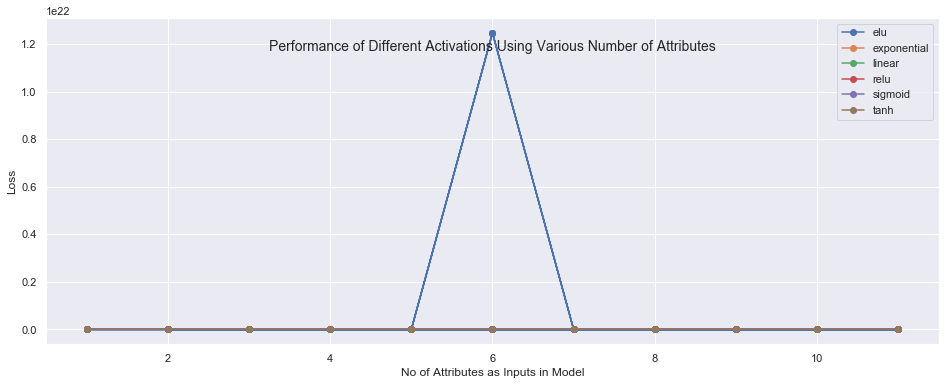

In [37]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]
groups = df.groupby(["activation"])

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for activation, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=activation)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Activations Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

Text(0.5, 0.9, 'Performance of Different Optimiser Using Various Number of Attributes')

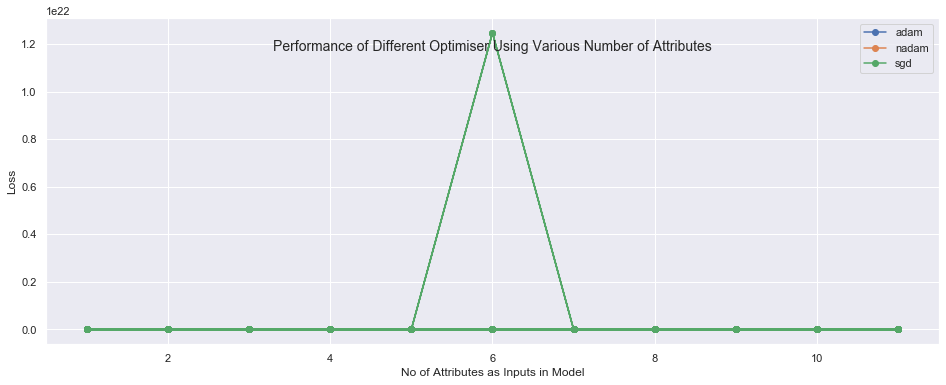

In [38]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]
groups = df.groupby('optimiser')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for optimiser, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=optimiser)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Optimiser Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

In [39]:
# Sort the various model iterations according to loss to determine the best model(s) to chose) 
df.sort_values(by='loss', ascending=True)

,no_attrib,scaling,test_size,activation,optimiser,no_epochs,batch_size,loss
439,11,True,0.3,exponential,nadam,100,10,8.280677
580,9,True,0.3,elu,nadam,100,10,8.297373
514,9,True,0.3,elu,nadam,100,10,8.297373
712,9,True,0.3,elu,nadam,100,10,8.297373
504,10,True,0.3,exponential,nadam,100,10,8.620350
570,10,True,0.3,exponential,nadam,100,10,8.620350
702,10,True,0.3,exponential,nadam,100,10,8.620350
184,9,True,0.3,elu,sgd,100,10,8.959424
316,9,True,0.3,elu,sgd,100,10,8.959424
107,9,True,0.3,exponential,adam,100,10,9.063955
